___
<img style="float: right; margin: 15px 15px 15px 15px;" src="https://www.techexplorist.com/wp-content/uploads/2023/05/human-dna-1024x683.jpg" width="300px" height="180px" />


# <font color= #bbc28d> **DNA Alignment Sequence** </font>
#### <font color= #2E9AFE> `Lab 1 – Text Mining`</font>
- <Strong> Sofía Maldonado, Diana Valdivia & Viviana Toledo </Strong>
- <Strong> Fecha </Strong>: 21/09/2025 

___

<p style="text-align:right;"> Imagen recuperada de: https://www.techexplorist.com/wp-content/uploads/2023/05/human-dna-1024x683.jpg</p>

# <font color= #bbc28d> **Objective** </font>
In this notebook, we will compare short DNA pair sequences to a human genome sequence. The goal is to understand how sequences align using the two main algorithms seen on class:
- `Needleman-Wunsch` – for **global** alignment (whole sequences).
- `Smith-Waterman` – for **local** alignment (best matching subsequences).

Both algorithms will be run with the following parameters, and only the **best-scoring** sequence will be selected for comparison with Biopython:
- **Match**: +2
- **Mismatch**: –1
- **Gap**: –2

Additionally, we will test parameter sensitivity using the **top 3 highest-scoring** pairs.

# <font color= #bbc28d> **Modules** </font>
First, let’s import all the modules we’ll be using throughout this notebook:

In [48]:
# Libraries
# Time counter
import time

# Matrixs
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Bio Python
from Bio import Entrez, SeqIO, pairwise2

# <font color= #bbc28d> **Homosapiens Mitochondrial DNA** </font>

For this lab, we will be working with the human **BRCA2 gene on chromosome 13**, obtained from GenBank. Since the sequence pairs we are comparing are 100 bp long, we selected a **100 bp segment** from the genome for alignment.

To maximize the alignment score, we tested approximately **30 different starting positions** along the genome. The best alignment was achieved at `31225363`:

In [49]:
# We will use the Biopython Library to simplify getting the sequences
# Using the BRAC2 gene, a well-known gene which is considered a tumor supressor
brac2_id = "NC_000013.11"

Entrez.email = ""

handle1 = Entrez.efetch(db="nucleotide", id=brac2_id, rettype="fasta", retmode="text")
record1 = SeqIO.read(handle1, "fasta")
handle1.close()

# Because of the size of this gene, we will only take small chunks to compare

starting_pos = 31225363
ending_pos = starting_pos + 100 # length of 100 bp

# Save the sequence slicing in a variable
original_sequence = record1.seq[starting_pos:ending_pos]

In total, we have **10 sequence** pairs. For each pair, we also have to consider the **reversed version**, giving us a total of **20 sequences to align**:

In [50]:
# Dictionary of the pair sequences
# The first element is the normal, and the second one is the reversed
pairs = {'pair1': ('GACTTACGCGCCGTAGCACTTCTGTGATAGCTGCGAGGCGTATTGCTACTTGTACGAGATAGGGTCGACTTTTCGGAGTCGACAGACACTACGATACT',
                   'AGTATCGTAGTGTCTGTCGACTCCGAAAAGTCGACCCTATCTCGTACAAGTAGCAATACGCCTCGCAGCTATCACAGAAGTGCTACGGCGCGTAAGTC'),
         'pair2': ('GTAGTCATTACCCATAGGCGTTTGCTGACTATCGGGAGAGGTACGTACGTGATACGACTGTCGATCGCTCGTAGATCAAGATACTCAGCGTGCTGTC',
                   'GACAGCACGCTGAGTATCTTGATCTACGATCGACAGTCGTATCACGTACGTACCTCTCCCGATAGTCAGCAAACGCCTATGGGTAATGACTAC'),
         'pair3': ('CTGCATACCGACAAACGTGTGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCACATGCATACGTGCGTGTCTACGTACGT',
                   'ACGTACGTCTACGCACGTATGCATGTGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCACACGTTTGTCGGTATGCAG'),
         'pair4': ('GGATGCGACTAGGAGTCGAGTGTCGATTCTATAGCGATAGCGAGTAGCGACTAGTCACTGTACTGTAGCATAGCGATACGAGCATAGCATAGCA',
                   'TGCTATGCTATGCTCGTATCGCTATGCTACAGTGACTAGTCGCTACTCGCTATCGCTATAGAATCGACACTCGACTCCTAGTCGCATCC'),
         'pair5': ('TCGATCGTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGC',
                   'GCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTACGATCGAC'),
         'pair6': ('ATGCGTATACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACG',
                   'CGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTATACGCAT'),
         'pair7': ('TTAAATTATATATATACGCGCGCGCGACACACACACACTGATCTATACGCGCGCGCGCGATAGCGATAGCGATCGATCGCGCTATATATATA',
                   'TATATATAGCGCGATCGATCGCTATCGCTATCGCGCGCGCGTATAGATCAGTGTGTGTGTGTCGCGCGCGCGTATATATATAATTTAA'),
         'pair8': ('CTACTGAGTCGTAGCTAGCGAGTCGAGTGCGTGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGC',
                   'GCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCATGCACGACTCGACTCGCTAGCTACGACTCAGTAG'),
         'pair9': ('GCATGCGACTTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCATGC',
                   'GCATGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAAGTCGCATGC'),
         'pair10': ('CGCGATAGCGATAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAG',
                    'CTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTATCGCTATCGCG')}

# <font color= #bbc28d> **Needleman-Wunsch Algorithm** </font>
The Needleman-Wunsch algorithm was created by **Saul B. Needleman and Christian D. Wunsch** in 1970. It is used to compute the **global alignment** of protein or nucleotide sequences. 

It works in two steps. First, it creates a scoring grid of size (nm) with n and m being the length of the sequences. Then, it scores the similarity between elements of a sequence with defined match_score, mismatch_penalty and gap_penalty values. The final value on the grid (the value at M(m,n)), is the alignment score.

Then, to return the optimal alignments, the algorithm performs a traceback, going backwards from the final position back to M(1,1). The move back goes through a diagonal if the items align but may also go up or to the left if they do not align, **always looking for the biggest value** until it returns to the beginning. 

In [51]:
### NEEDLEMAN-WUNSCH
def needleman_wunsch(seq1, seq2, MATCH_SCORE, MISMATCH_PENALTY, GAP_PENALTY):

    start = time.perf_counter()

    def similarity(a,b, MATCH_SCORE, MISMATCH_PENALTY):
        if a == b:
            return MATCH_SCORE
        else:
            return MISMATCH_PENALTY

    # Creating the empty matrix
    nwm = np.zeros((len(seq1) + 1,len(seq2) + 1))

    # Assigning starter values
    for i in range(nwm.shape[0]):
        for j in range(nwm.shape[1]):
            nwm[i,0] = GAP_PENALTY * i
            nwm[0,j] = GAP_PENALTY * j   

    #Filling out the rest of the matrix
    for i in range(1,nwm.shape[0]):
        for j in range(1, nwm.shape[1]):            
            top_value = nwm[i-1,j] + GAP_PENALTY
            left_value = nwm[i, j-1] + GAP_PENALTY

            if seq1[i-1] == seq2[j-1]:
                diagonal_value = nwm[i-1, j-1] + MATCH_SCORE
            else:
                diagonal_value = nwm[i-1, j-1] + MISMATCH_PENALTY

            nwm[i,j] = max(top_value, left_value, diagonal_value)
    
    #Traceback

    sequence1 = ''
    sequence2 = ''
    path_x = []
    path_y = []

    i, j = len(seq1), len(seq2)

    while (i > 0 or j > 0):
        path_x.append(i)
        path_y.append(j)

        if (i > 0 and j > 0 and nwm[i,j] == nwm[i-1,j-1] + similarity(seq1[i-1], seq2[j-1], MATCH_SCORE, MISMATCH_PENALTY)):
            sequence1 = seq1[i-1] + sequence1
            sequence2 = seq2[j-1] + sequence2
            i -= 1
            j -= 1
        elif (i > 0 and nwm[i,j] == nwm[i-1, j] + GAP_PENALTY):
            sequence1 = seq1[i-1] + sequence1
            sequence2 = '-' + sequence2
            i -= 1
        else:
            sequence1 = '-' + sequence1
            sequence2 = seq2[j-1] + sequence2
            j -= 1
    
    score = nwm[len(seq1), len(seq2)]
    time_taken = time.perf_counter() - start # The time taken to visualize the graph is not considered as time to complete the algorithm, so the timer stops here

    # Heatmap
    fig = plt.figure(figsize=(8,8))
    sns.heatmap(nwm, xticklabels=[], yticklabels=[])
    plt.plot([x + 0.5 for x in reversed(path_x)],
             [y + 0.5 for y in reversed(path_y)],
             linewidth = 2, color='green')
    
    plt.title(f"Needleman-Wunsch - SCORE = {score}, \n Match Score = {MATCH_SCORE}, Mismatch Penalty = {MISMATCH_PENALTY}, Gap Penalty = {GAP_PENALTY}")

    return nwm, sequence2, sequence1, score, time_taken, fig

### <font color= #bbc28d> **Needleman-Wunsch Algorithm on the 10 pairs** </font>
The Needleman-Wunsch algorithm will be applied to each sequence. For visualization, the alignment scores will be plotted, but only the top 3 sequences with the highest scores will be printed:

Top 3 sequences & their score: [(56.0, 'pair3'), (54.0, 'pair3_reverse'), (52.0, 'pair2_reverse')]


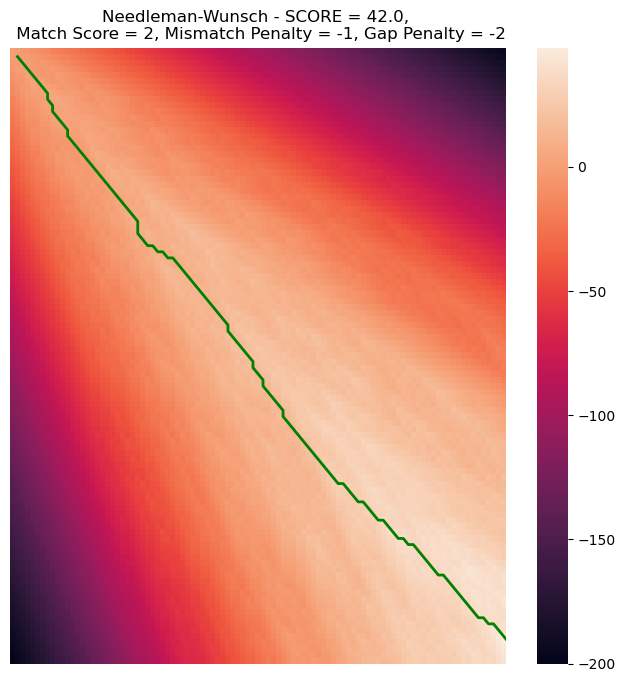

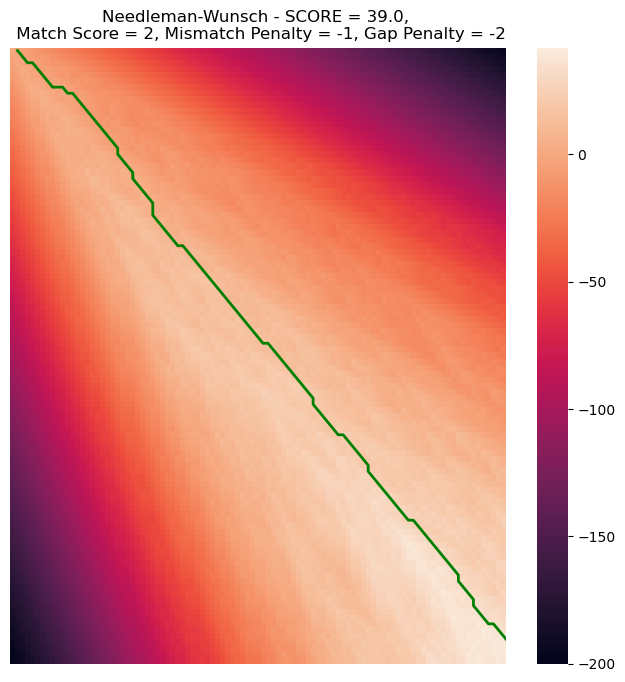

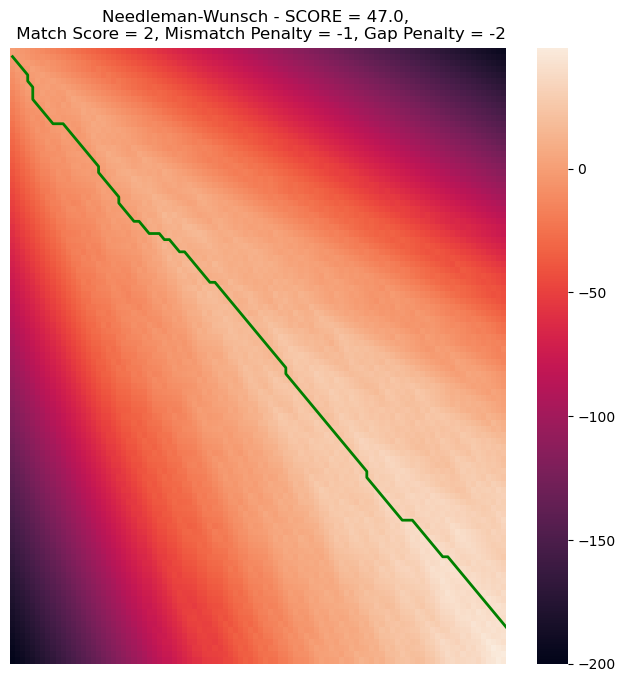

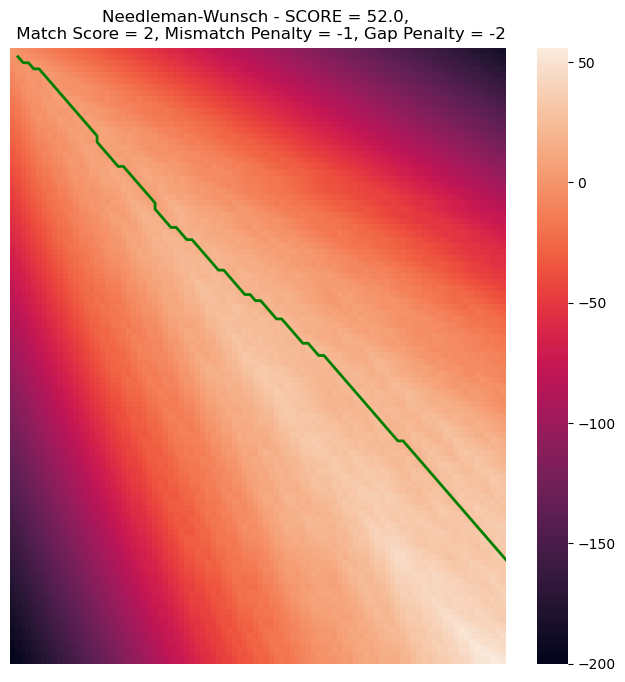

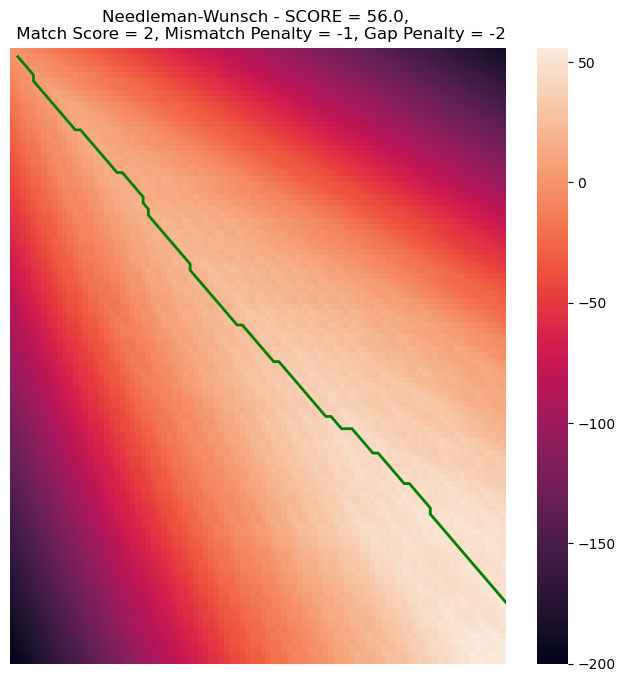

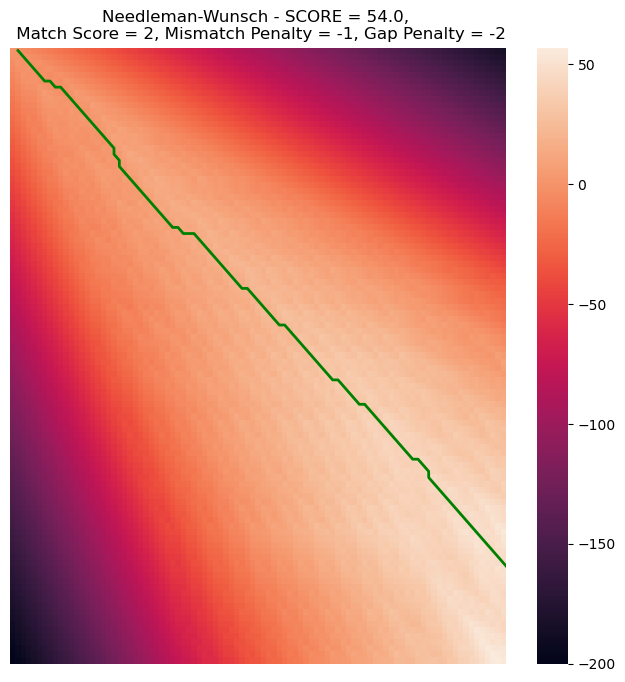

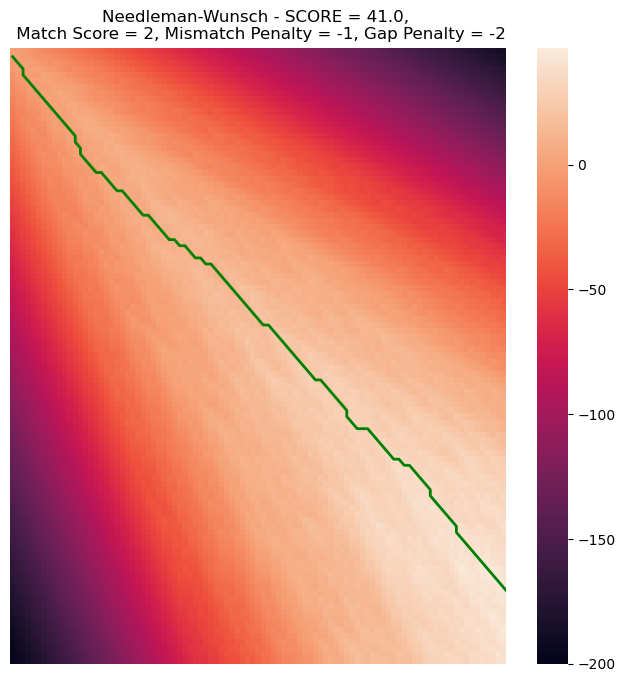

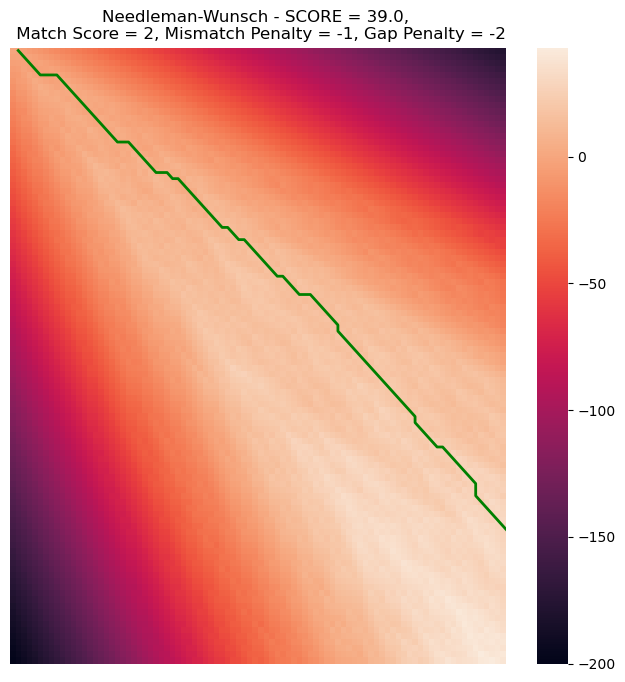

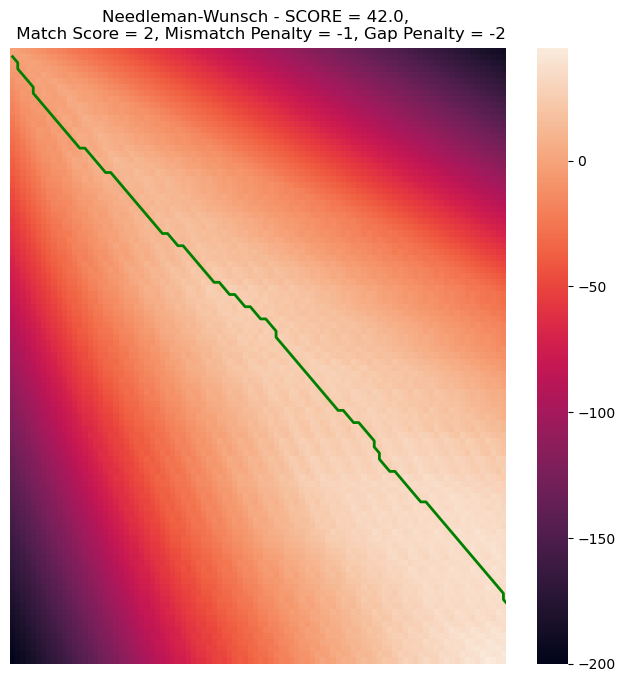

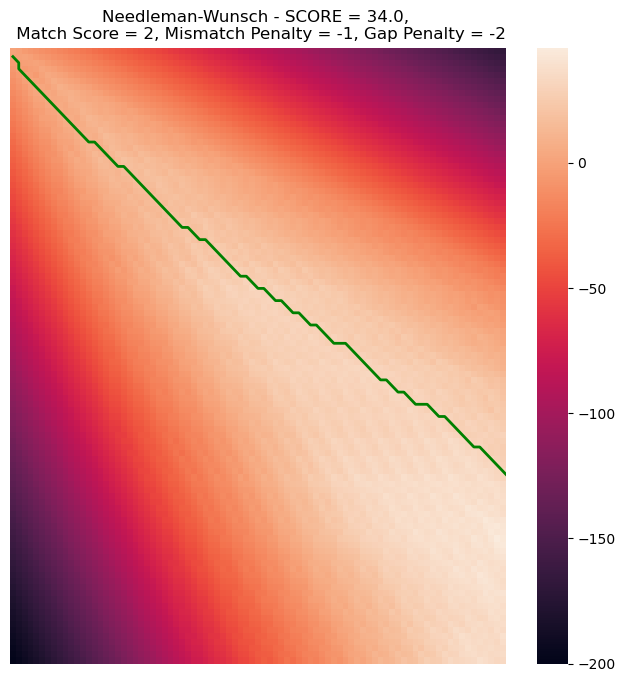

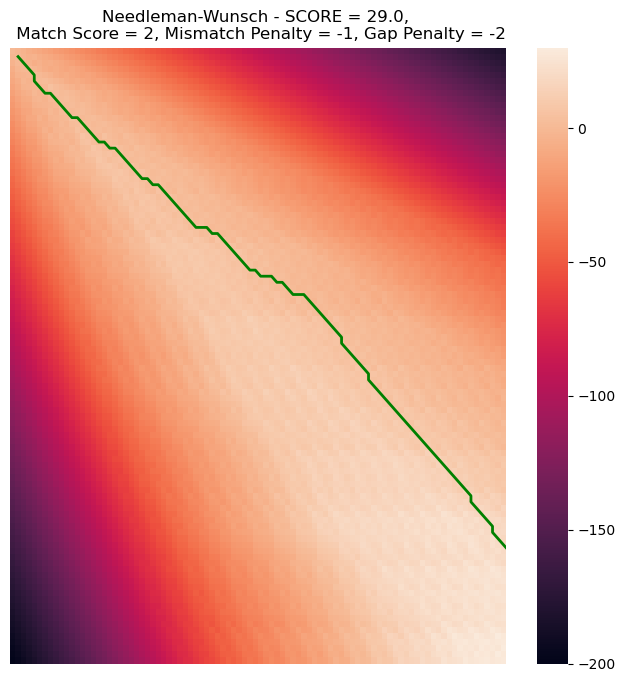

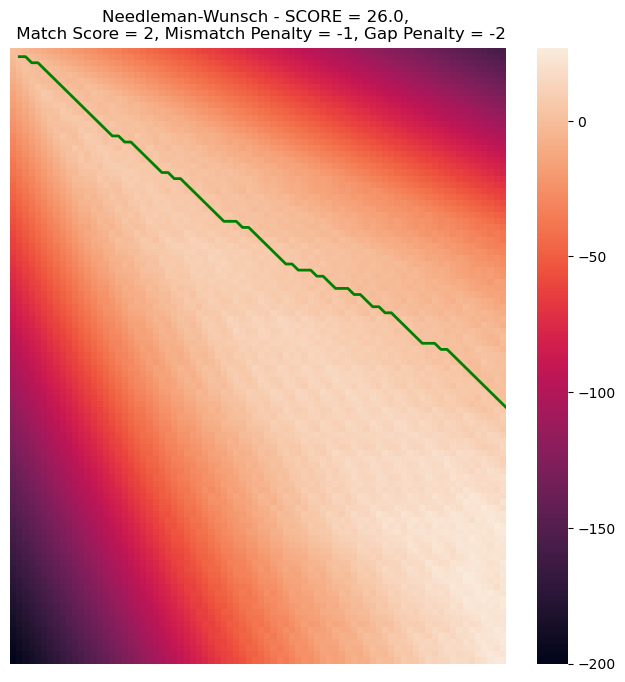

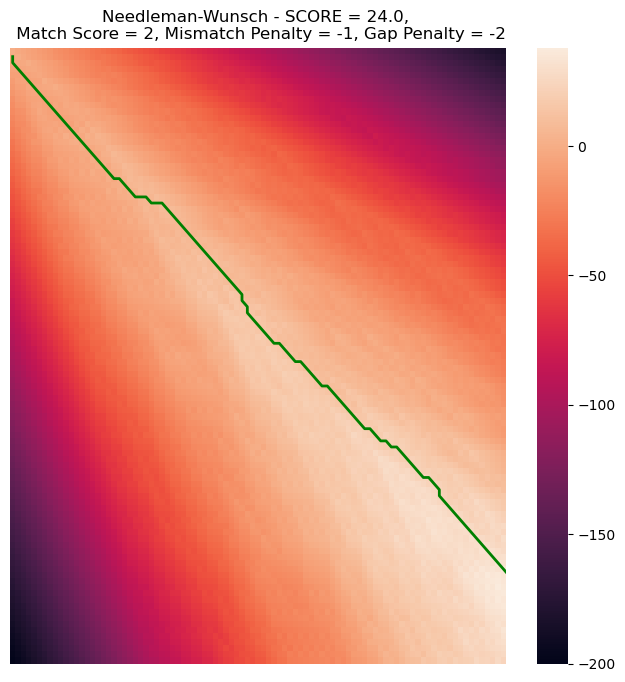

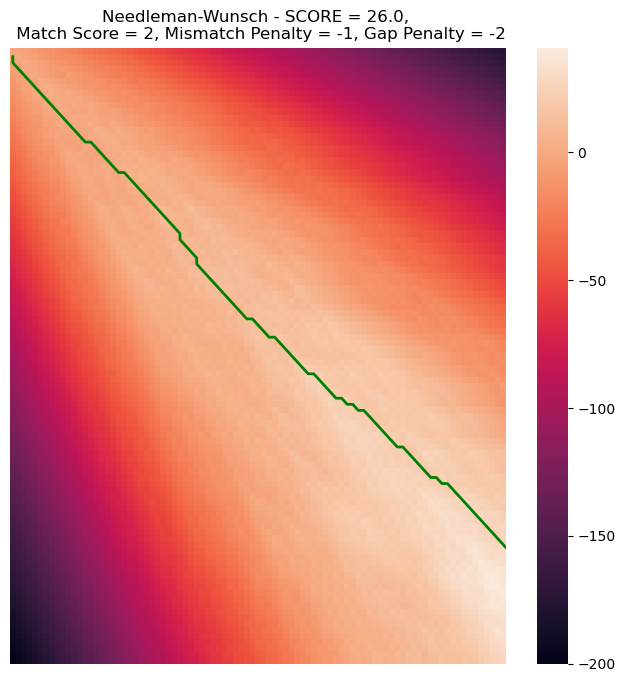

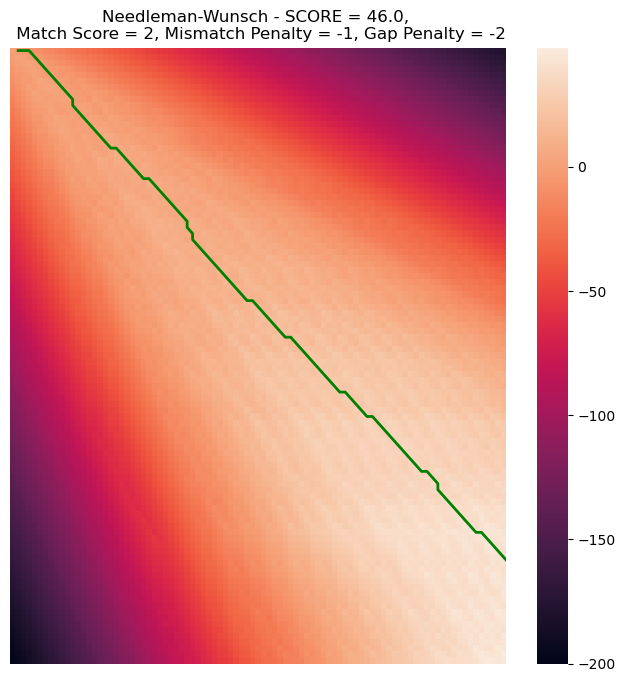

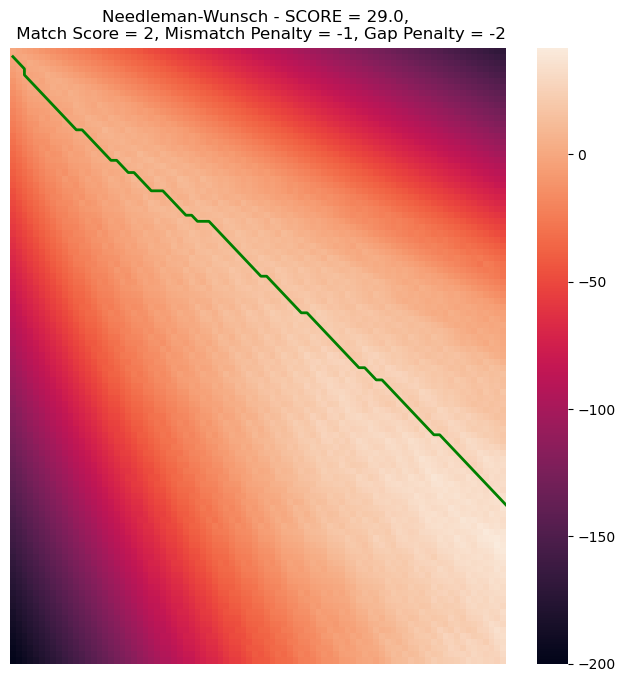

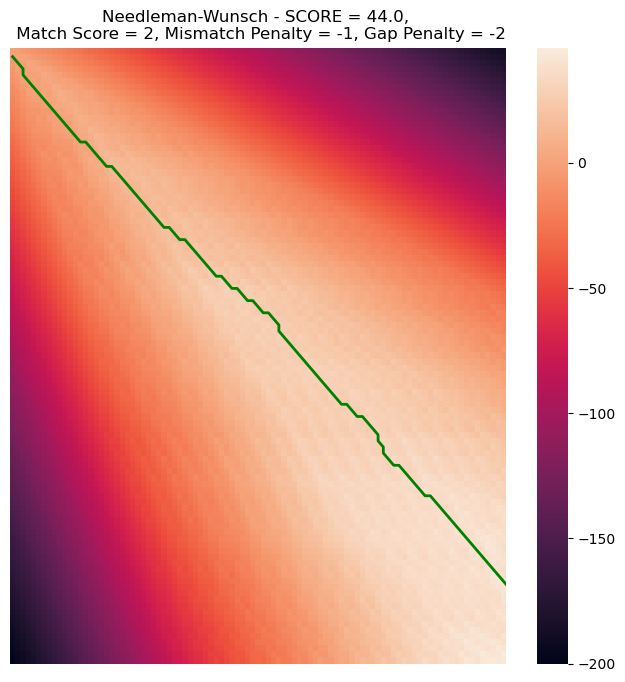

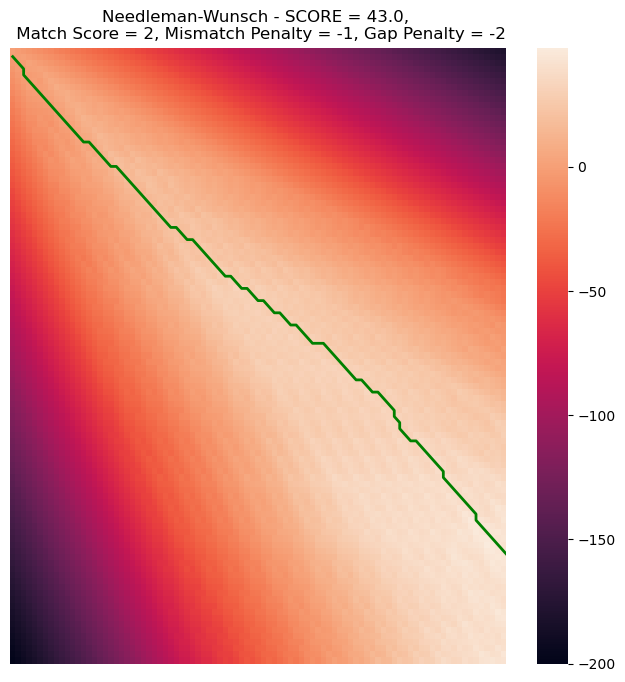

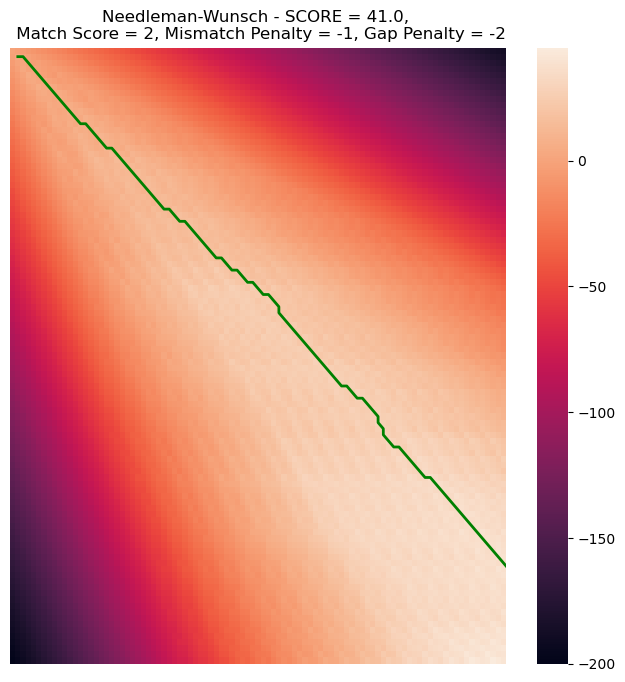

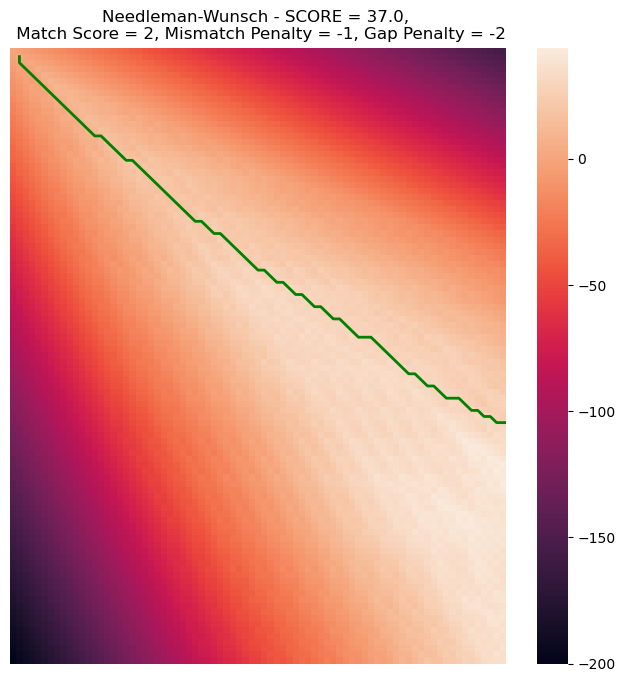

In [52]:
# List to save the results (score, sequence)
results = []


for i in range(1, len(pairs)+1):  
    # key to the dictionary  
    llave = f'pair{i}'

    # algorithm for the original sequence
    algorithm_og = needleman_wunsch(original_sequence, pairs[llave][0], 2, -1, -2)

    # algorithm for the reversed sequence
    algorithm_reverse = needleman_wunsch(original_sequence, pairs[llave][1], 2, -1, -2)

    # Save both scores
    score_og = algorithm_og[3]
    score_reverse = algorithm_reverse[3]

    # Add them to the list
    results.append((score_og, f"pair{i}"))
    results.append((score_reverse, f"pair{i}_reverse"))

# Sort the results by score in descending order
sorted_results = sorted(results, key=lambda x: x[0], reverse=True)

# Take the top 3
top_3 = sorted_results[:3]
print(f'Top 3 sequences & their score: {top_3}')

# <font color= #bbc28d> **Parameter Sensitivity - NW** </font>
Modify match/mismatch/gap parameters and re-run alignment on 3 selected pairs. For this, the 3 scenarios we will try are the following:

- **Case 1**: Match score of `1`, mismatch penalty of `-10` & gap penalty `-1`.
- **Case 2**: Match score of `10`, mismatch penalty of `-1` & gap penalty `-1`.
- **Case 3**: Match score of `3`, mismatch penalty of `-1` & gap penalty `-2`.

Here are the scores with match: 1, mismatch: -10 & penalty -1
[(2.0, 'pair2_reverse'), (1.0, 'pair3'), (0.0, 'pair3_reverse')]


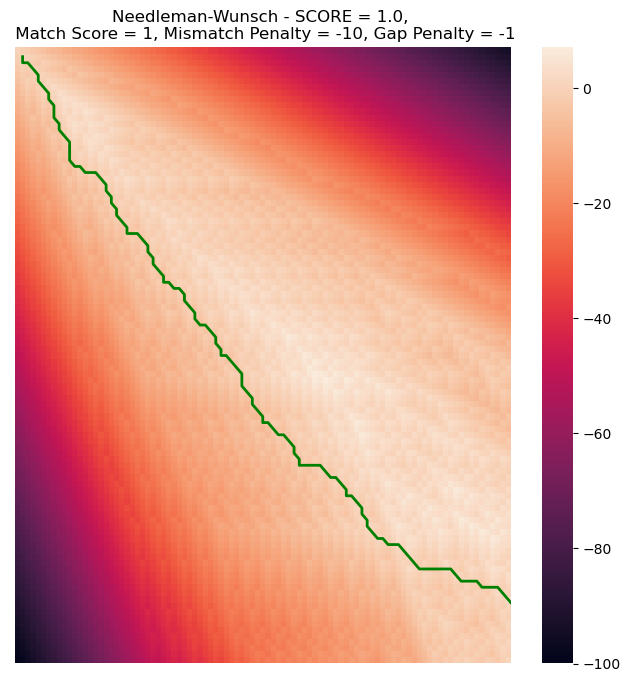

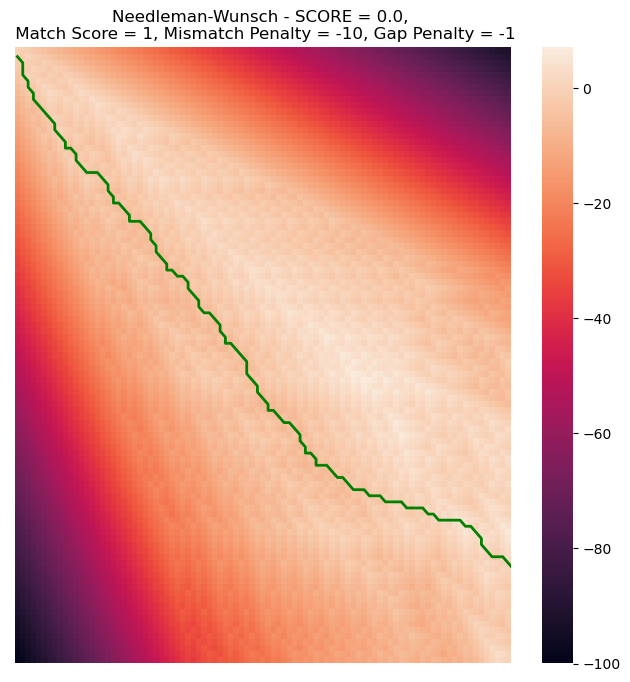

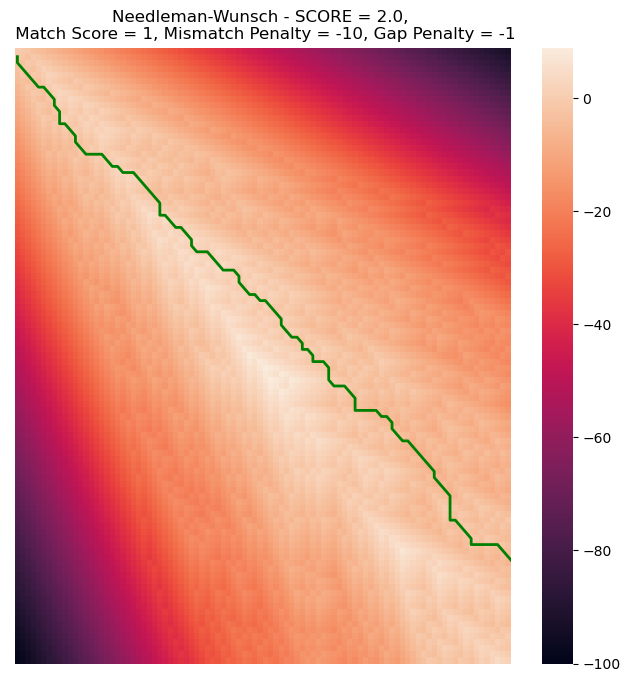

In [53]:
# Select the top 3 highest scoring pairs
pairs_params = list(map(lambda x: x[1], top_3))

# Save the score and name of the sequence
results = []

# Parameters
Match = 1
Mismatch = -10
Gap = -1


for name in pairs_params:
    # Check if it's the reversed sequence
    if name.endswith("_reverse"):
        # Change the key 
        key = name.replace("_reverse", "")
        sequence = pairs[key][1]  # take the reversed sequence
    else:
        sequence = pairs[name][0]  # take the original sequence
    
    # Apply the algorithm
    algorithm = needleman_wunsch(original_sequence, sequence, Match, Mismatch, Gap)

    # Save the score
    score = algorithm[3]
    results.append((score, name))

# Sort the scores from highest to lowest
results = sorted(results, key=lambda x: x[0], reverse=True)
print(f'Here are the scores with match: {Match}, mismatch: {Mismatch} & penalty {Gap}')
print(results)

Here are the scores with match: 10, mismatch: -1 & penalty -1
[(601.0, 'pair3'), (601.0, 'pair2_reverse'), (593.0, 'pair3_reverse')]


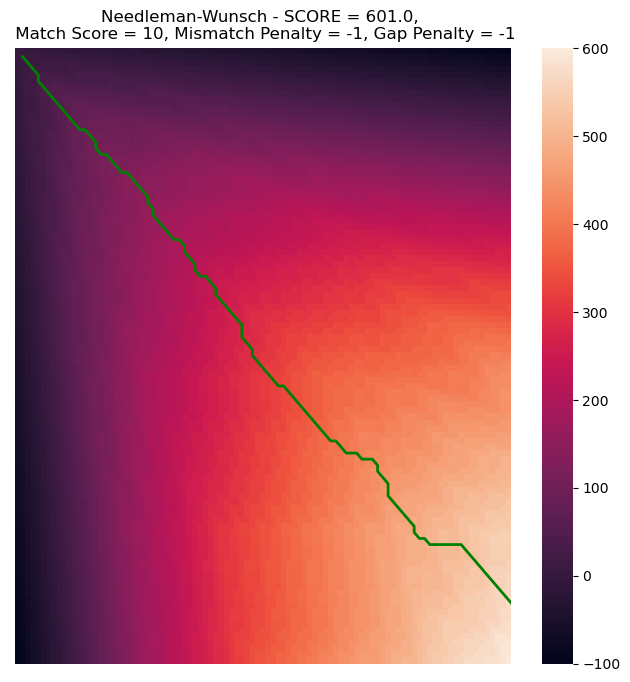

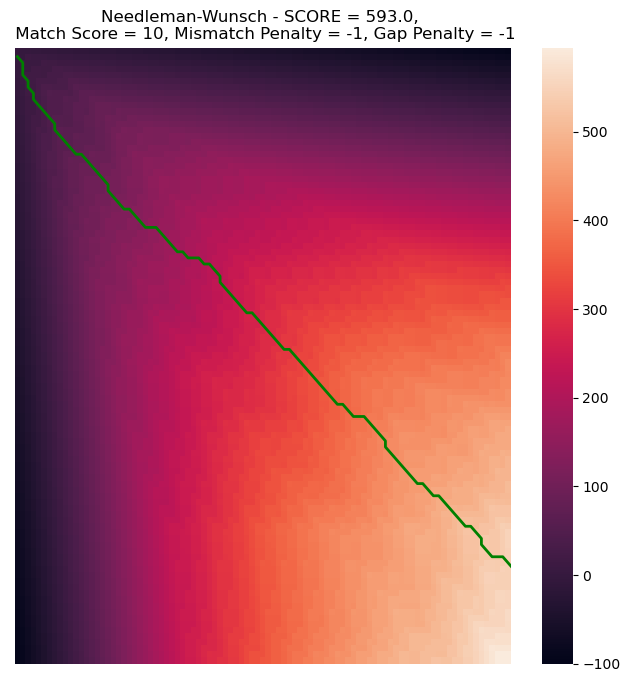

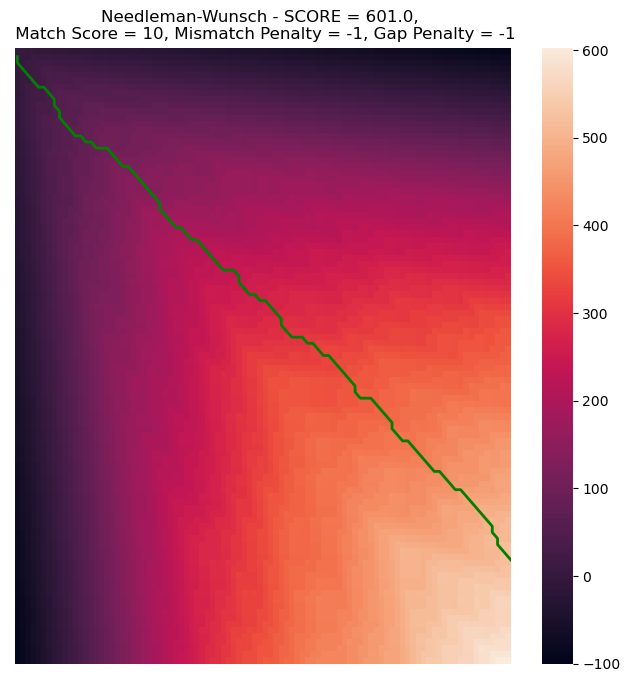

In [54]:
# Save the score and name of the sequence
results = []

# Parameters
Match = 10
Mismatch = -1
Gap = -1


for name in pairs_params:
    # Check if it's the reversed sequence
    if name.endswith("_reverse"):
        # Change the key 
        key = name.replace("_reverse", "")
        sequence = pairs[key][1]  # take the reversed sequence
    else:
        sequence = pairs[name][0]  # take the original sequence
    
    # Apply the algorithm
    algorithm = needleman_wunsch(original_sequence, sequence, Match, Mismatch, Gap)

    # Save the score
    score = algorithm[3]
    results.append((score, name))

# Sort the scores from highest to lowest
results = sorted(results, key=lambda x: x[0], reverse=True)
print(f'Here are the scores with match: {Match}, mismatch: {Mismatch} & penalty {Gap}')
print(results)

Here are the scores with match: 3, mismatch: -1 & penalty -2
[(119.0, 'pair3'), (116.0, 'pair3_reverse'), (114.0, 'pair2_reverse')]


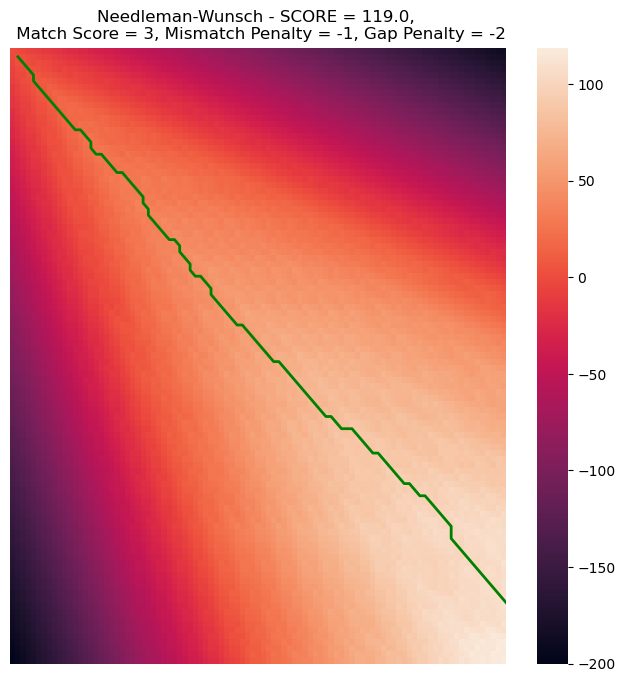

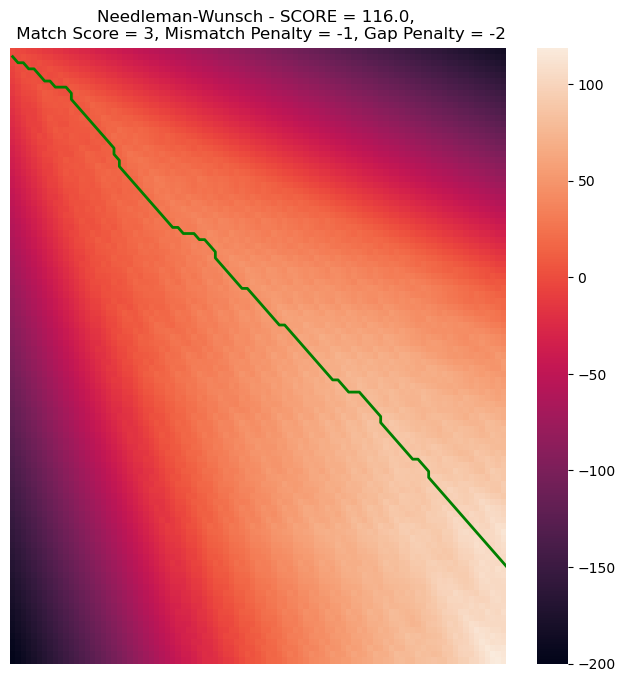

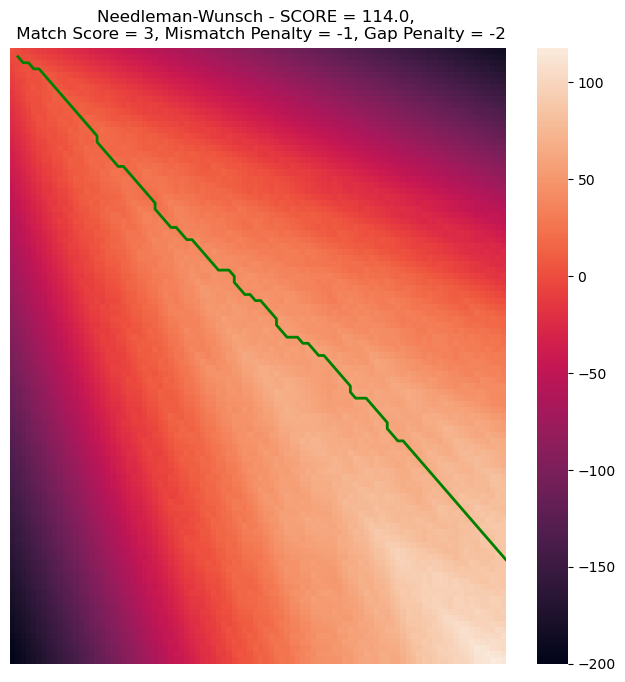

In [55]:
# Save the score and name of the sequence
results = []

# Parameters
Match = 3
Mismatch = -1
Gap = -2


for name in pairs_params:
    # Check if it's the reversed sequence
    if name.endswith("_reverse"):
        # Change the key 
        key = name.replace("_reverse", "")
        sequence = pairs[key][1]  # take the reversed sequence
    else:
        sequence = pairs[name][0]  # take the original sequence
    
    # Apply the algorithm
    algorithm = needleman_wunsch(original_sequence, sequence, Match, Mismatch, Gap)

    # Save the score
    score = algorithm[3]
    results.append((score, name))

# Sort the scores from highest to lowest
results = sorted(results, key=lambda x: x[0], reverse=True)
print(f'Here are the scores with match: {Match}, mismatch: {Mismatch} & penalty {Gap}')
print(results)

# <font color= #bbc28d> **Smith-Waterman** </font>
The Smith-Waterman Algorithm was developed by **Temple F. Smith and Michael S**. Waterman in 1981. Its objective is to perform **local sequence alignment** between two nucleotide or amino acid sequences and find out structural or functional similarity. 

It takes **inspiration from the Needleman-Wunsch Algorithm** and applies it on a local scale, to find out the optimal alignment based on a selected rating system (which includes the substitution matrix and gap scoring system). However, the negative scoring matrix defaults to zero, which makes local alignments visible (therefore, with positive scoring). 

Following the same procedure as the Needleman-Wunsh Algorithm, the tracking starts at the matrix cell with the **highest score** and continues until a cell with a **score of zero** is found, producing the local alignment with the highest score. It has a cubic complexity. 


In [56]:
def smith_waterman(seq1, seq2, match_score, mismatch_score, gap_penalty):
    # Iniciar cronómetro
    Inicio = time.perf_counter() 

    # Longitudes de las secuencias
    n, m = len(seq1), len(seq2)

    # Matriz de puntuaciones (n+1)x(m+1) inicializada en 0
    score_matrix = np.zeros((n+1, m+1), dtype=int)

    # Guardar máxima puntuación y su posición
    max_score = 0
    max_i = max_j = 0

    # Llenar la matriz
    for i in range(1, n+1):
        for j in range(1, m+1):
            # Puntaje match/mismatch
            s = match_score if seq1[i-1] == seq2[j-1] else mismatch_score

            match = score_matrix[i-1, j-1] + s
            delete = score_matrix[i-1, j] + gap_penalty
            insert = score_matrix[i, j-1] + gap_penalty

            # Tomar el máximo entre 0 y los tres movimientos
            score_matrix[i, j] = max(0, match, delete, insert)

            # Guardar la mejor celda
            if score_matrix[i, j] > max_score:
                max_score = score_matrix[i, j]
                max_i, max_j = i, j

    # Traceback
    seq_ord, seq_ord2 = [], []
    path_x, path_y = [], []
    i, j = max_i, max_j

    while score_matrix[i, j] > 0:
        path_x.append(i)
        path_y.append(j)

        s = match_score if seq1[i-1] == seq2[j-1] else mismatch_score

        if score_matrix[i, j] == score_matrix[i-1, j-1] + s:
            seq_ord.append(seq1[i-1])
            seq_ord2.append(seq2[j-1])
            i -= 1; j -= 1
        elif score_matrix[i, j] == score_matrix[i-1, j] + gap_penalty:
            seq_ord.append(seq1[i-1])
            seq_ord2.append('-')
            i -= 1
        else:
            seq_ord.append('-')
            seq_ord2.append(seq2[j-1])
            j -= 1

    seq_ord = ''.join(reversed(seq_ord))
    seq_ord2 = ''.join(reversed(seq_ord2))
    Fin = time.perf_counter()
    time_ = Fin - Inicio

    # Imprimir los resultados
    # print("First Sequence Aligned:", seq_ord)
    # print("Second Sequence Aligned:", seq_ord2)
    # print("Alignment Score:", max_score)
    # print(f"Time Taken: {time_:.4f} seconds")

    # Matriz de confusión con el traceback
    plt.figure(figsize=(10, 8))
    sns.heatmap(score_matrix,
                fmt='d',
                cmap='YlGnBu',
                xticklabels=['-']+list(seq2),
                yticklabels=['-']+list(seq1))

    # Camino del traceback
    plt.plot([y+0.5 for y in reversed(path_y)],
             [x+0.5 for x in reversed(path_x)],
             lw=2, color='blue')

    # Punto de inicio
    plt.scatter(max_j+0.5, max_i+0.5, color='red', s=50, label='Inicio')
    plt.title(f"Matriz Smith-Waterman (local alignment) - Score: {max_score} \n Match Score = {match_score}, Mismatch Penalty = {mismatch_score}, Gap Penalty = {gap_penalty}")
    plt.ylabel("Secuencia 1")
    plt.xlabel("Secuencia 2")
    plt.legend(loc='upper right')
    #plt.show()

    return seq_ord, seq_ord2, max_score, score_matrix, time_ # Esto es solo si se quiere almacenar el valor en algún lado :)

Top 3 sequences & their score: [(61, 'pair3_reverse'), (57, 'pair2_reverse'), (56, 'pair3')]


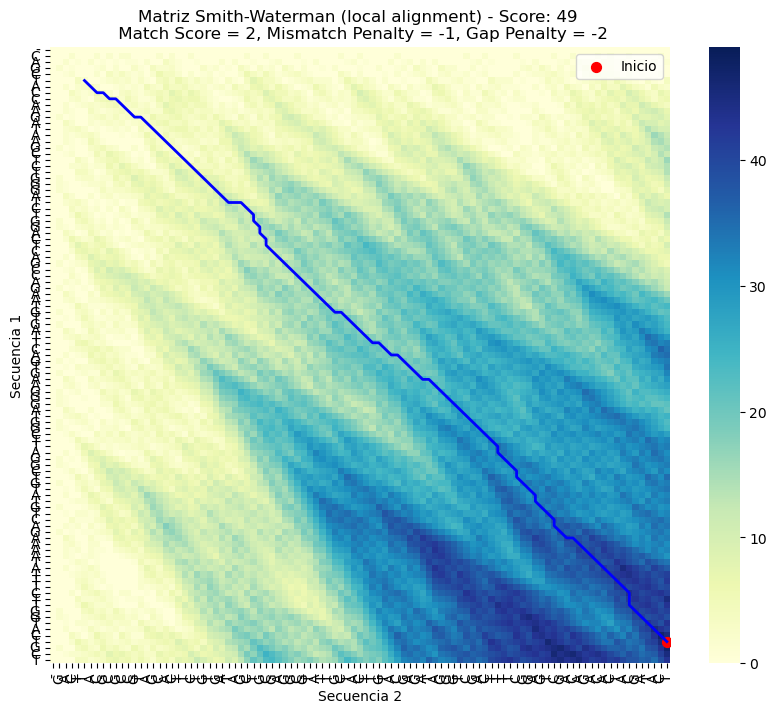

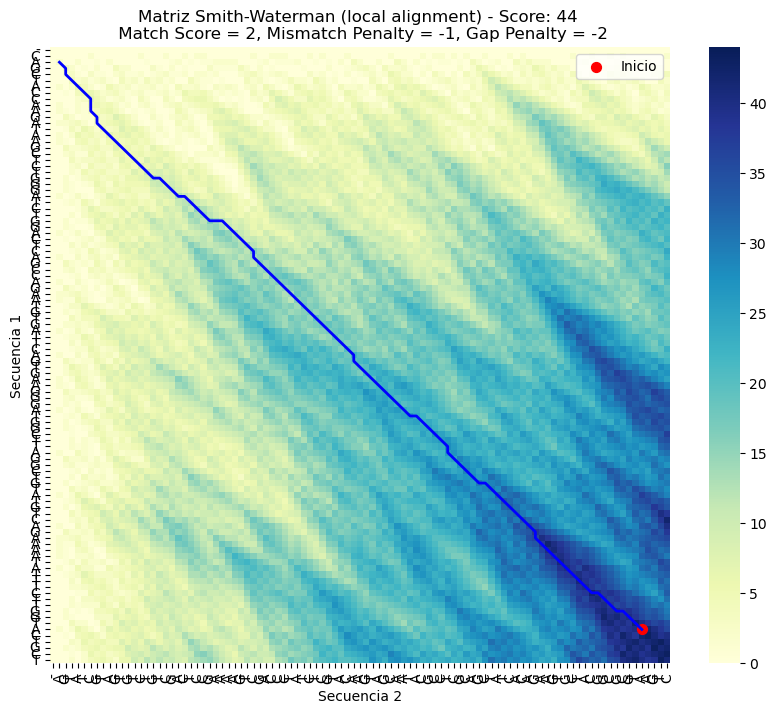

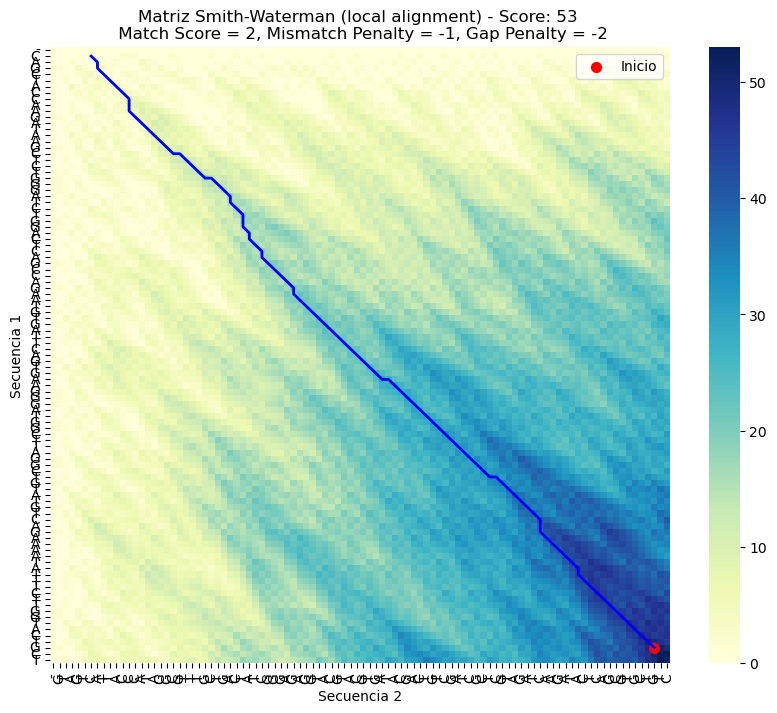

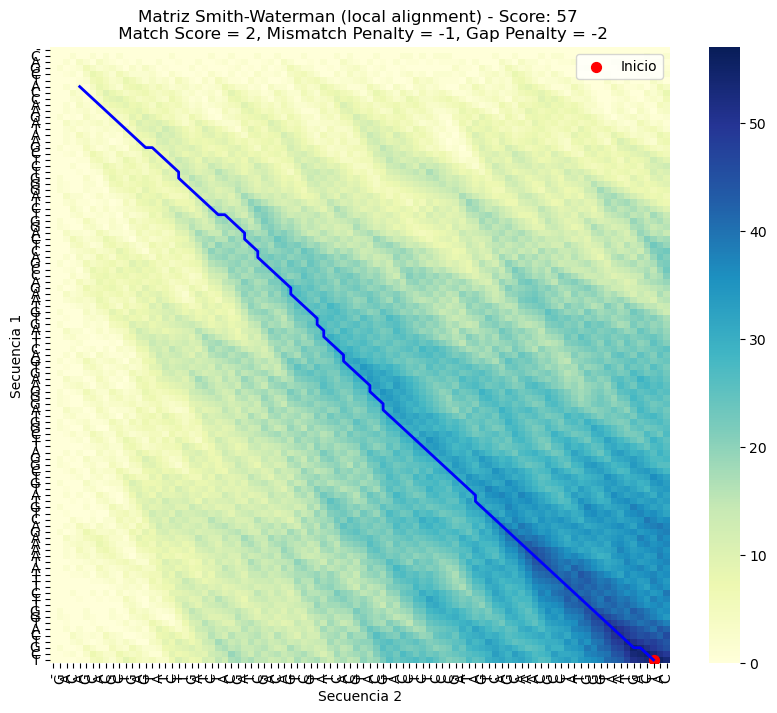

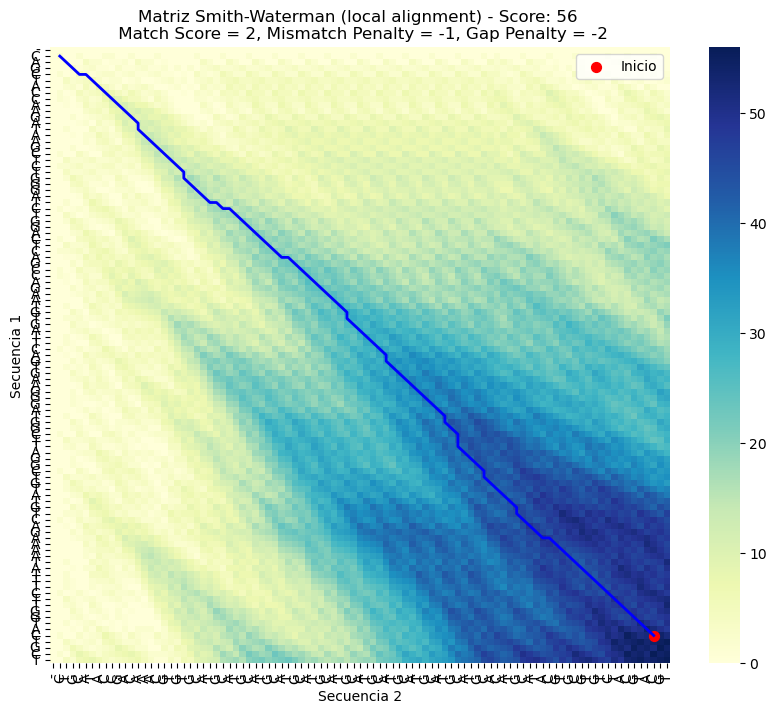

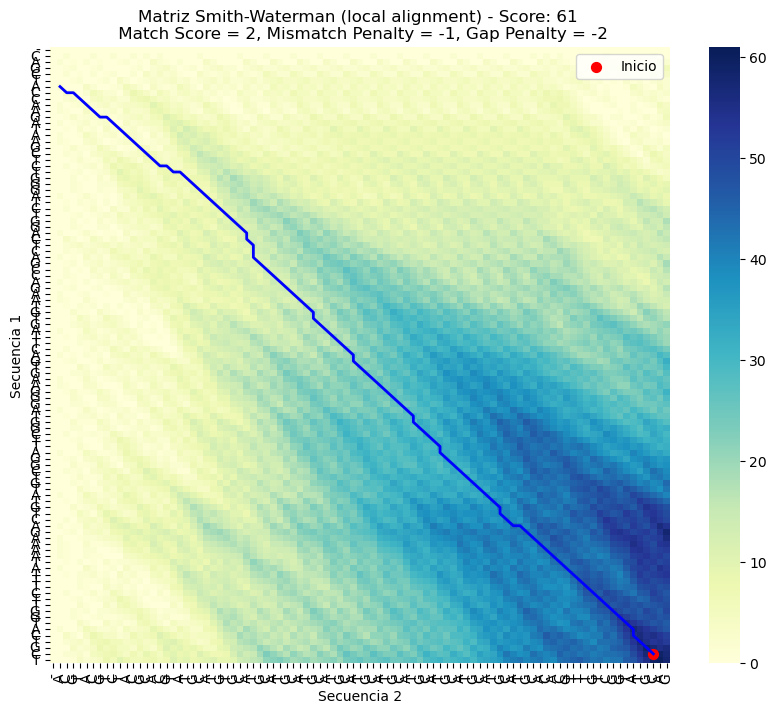

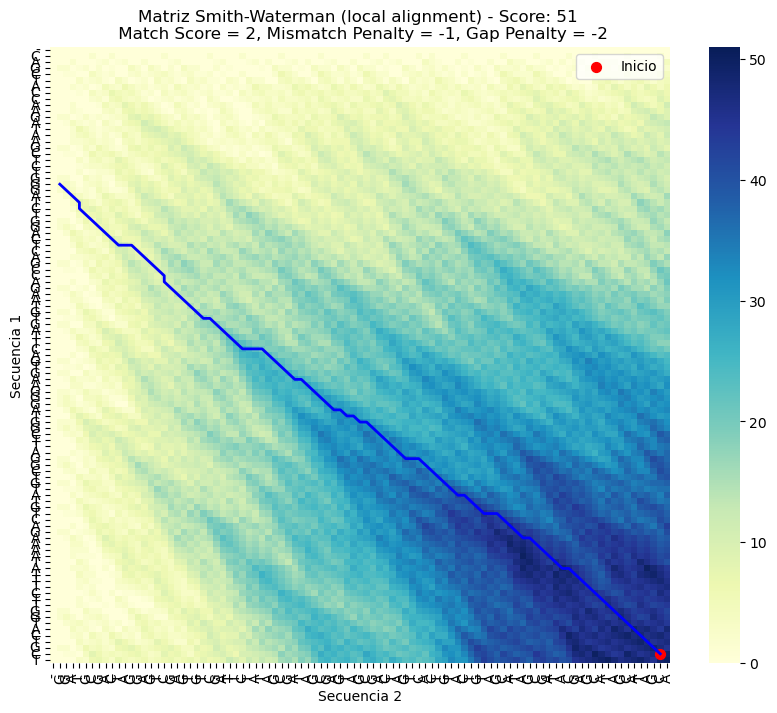

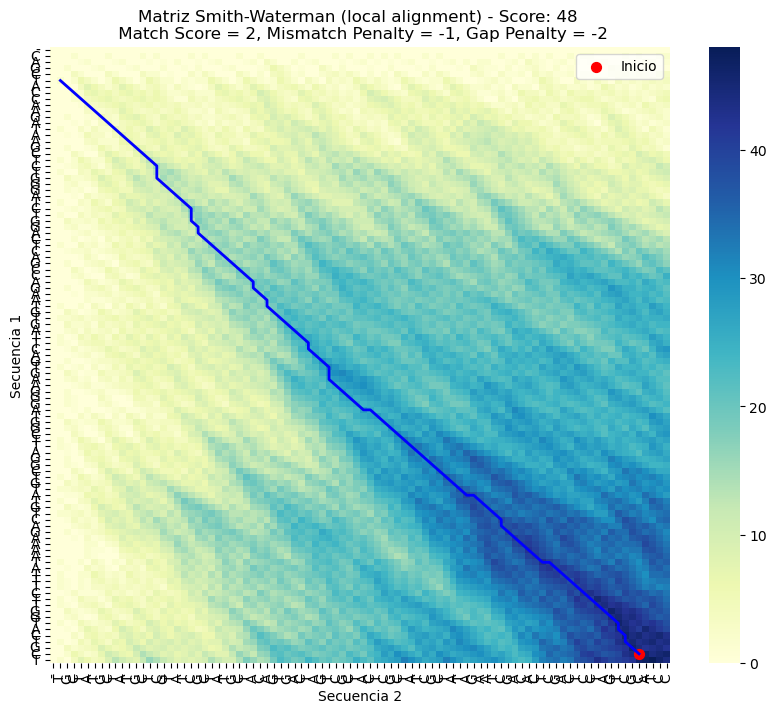

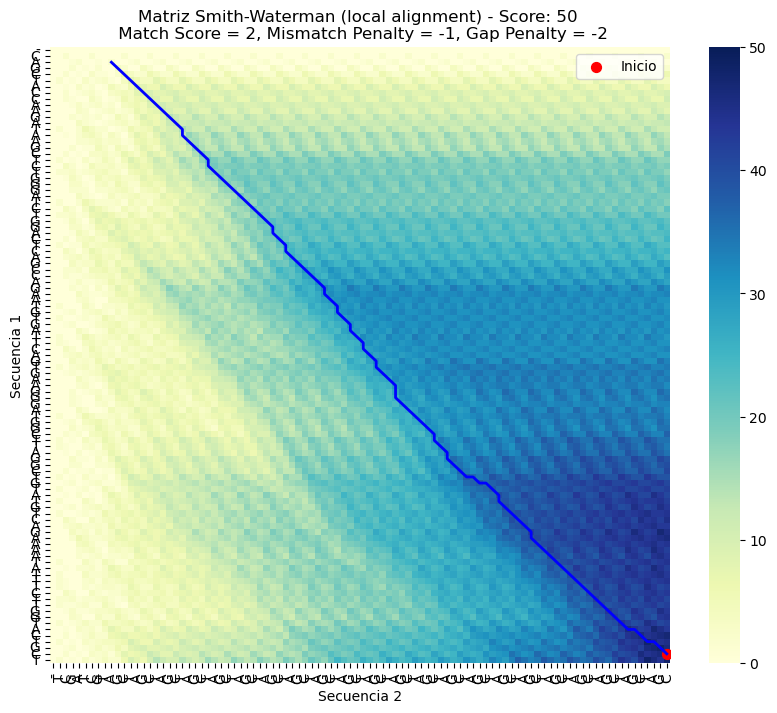

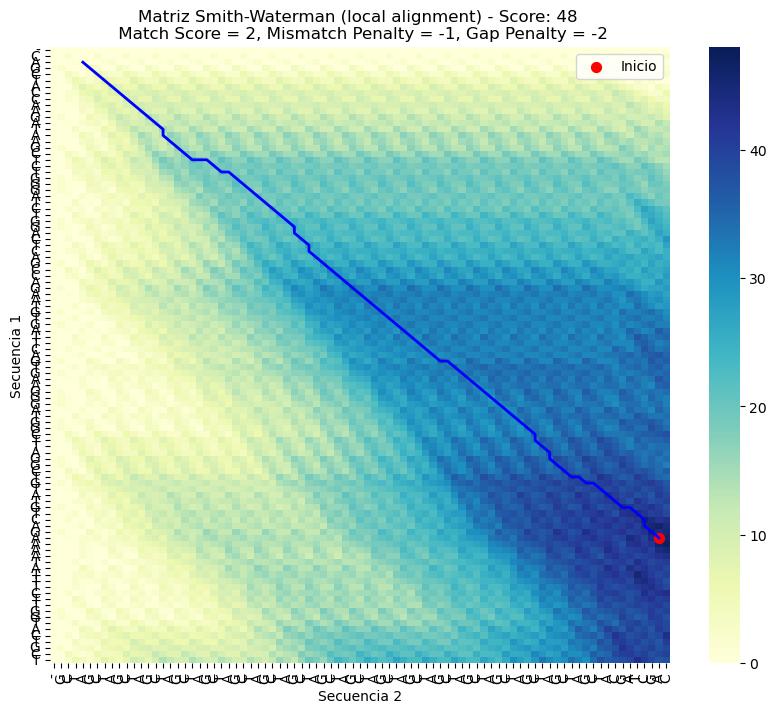

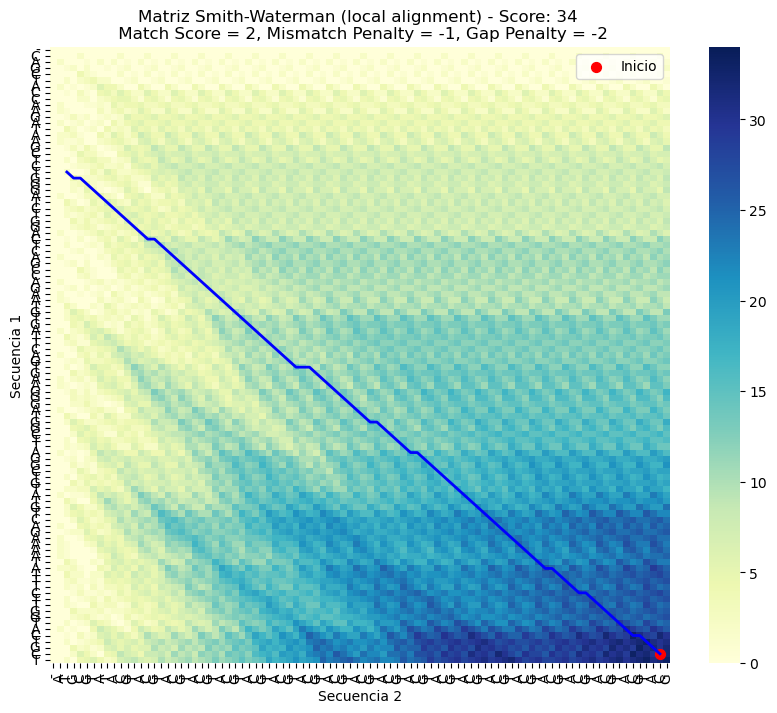

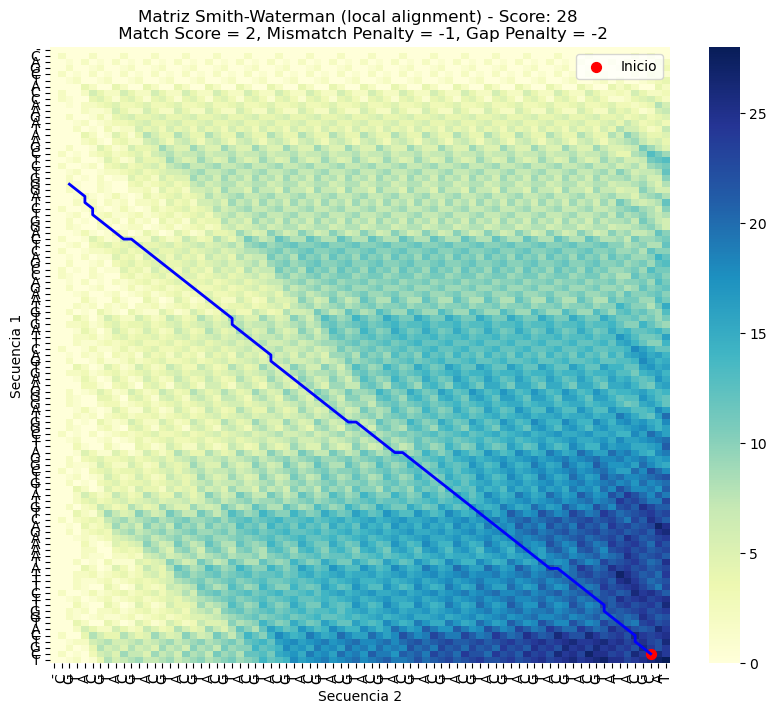

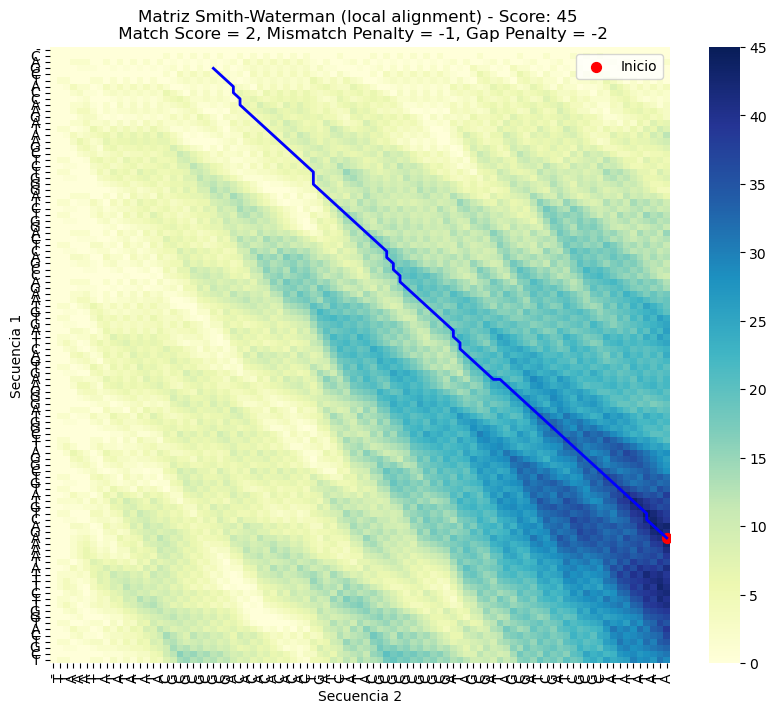

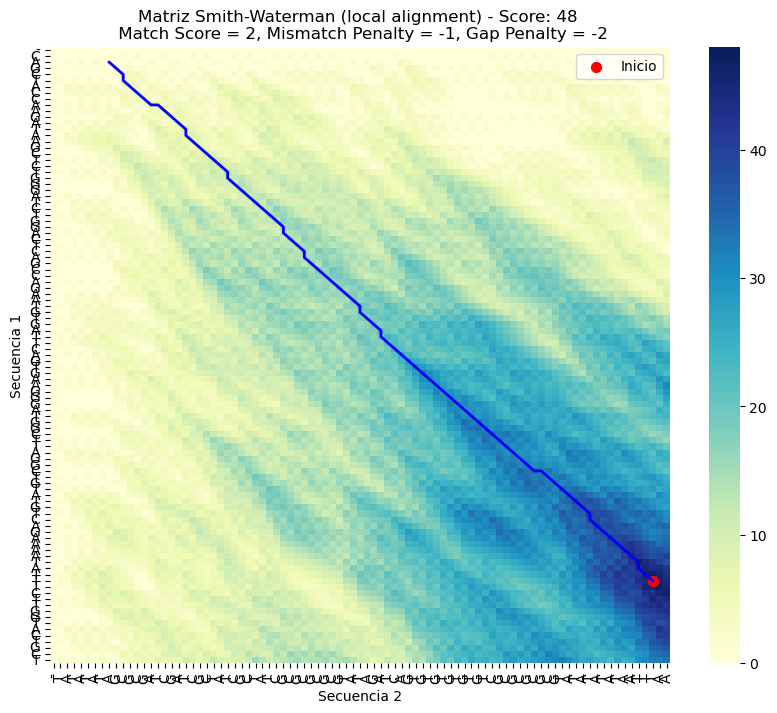

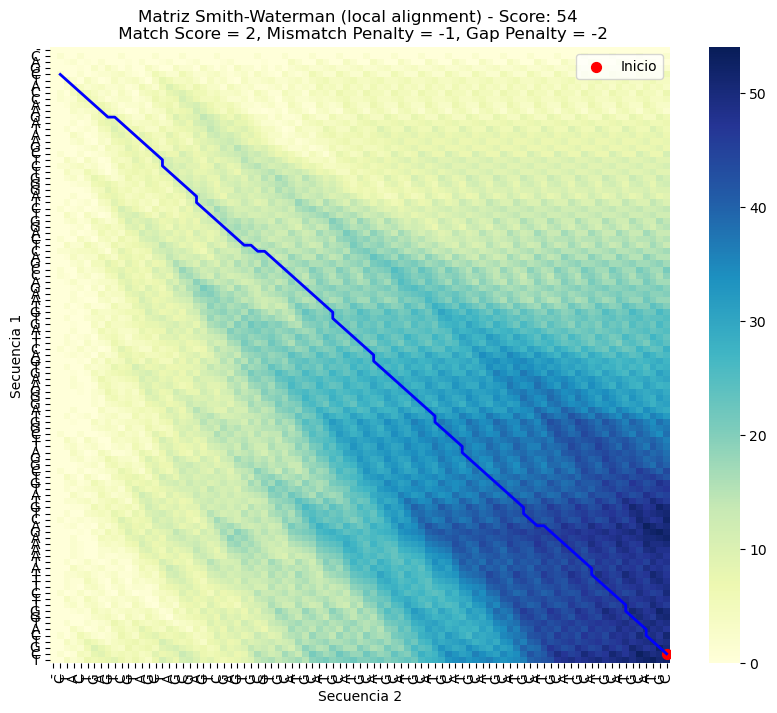

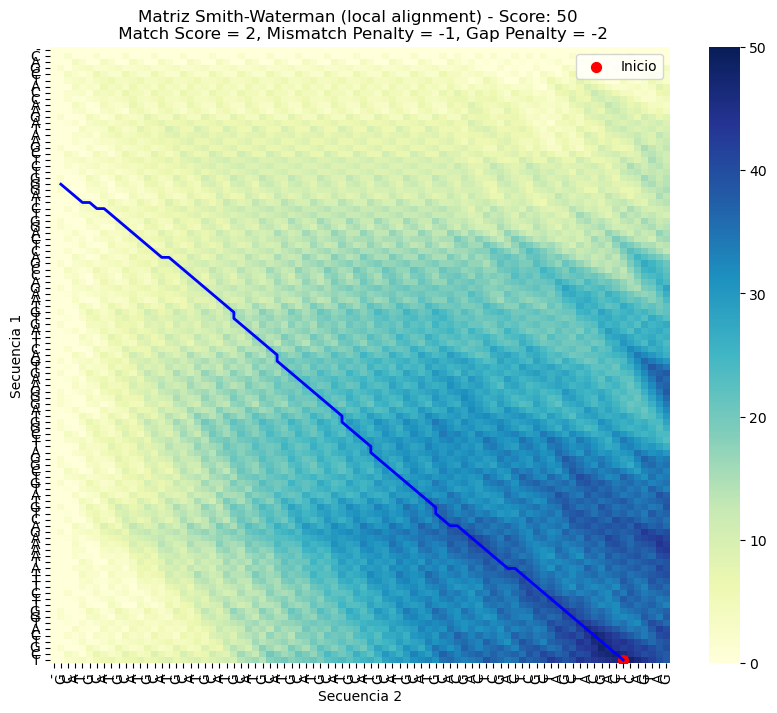

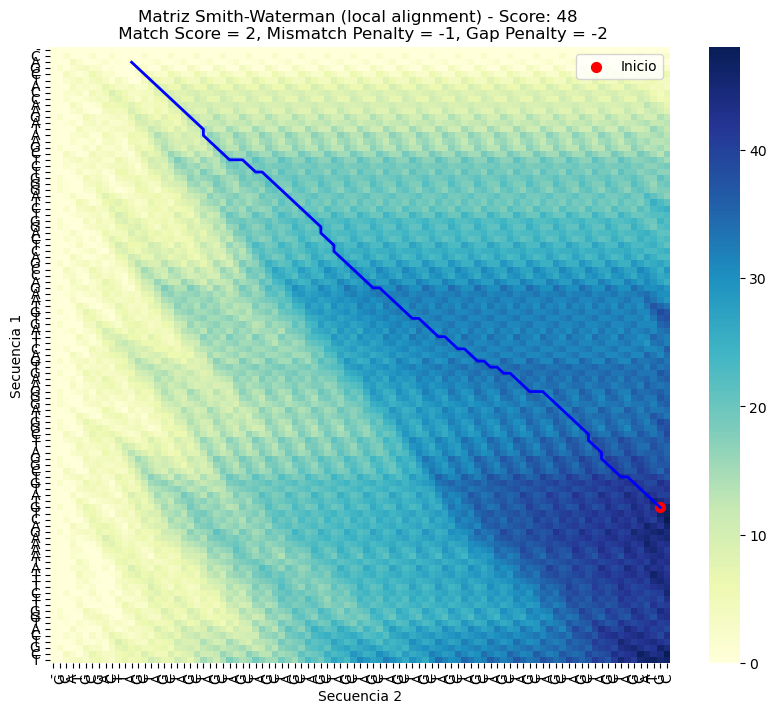

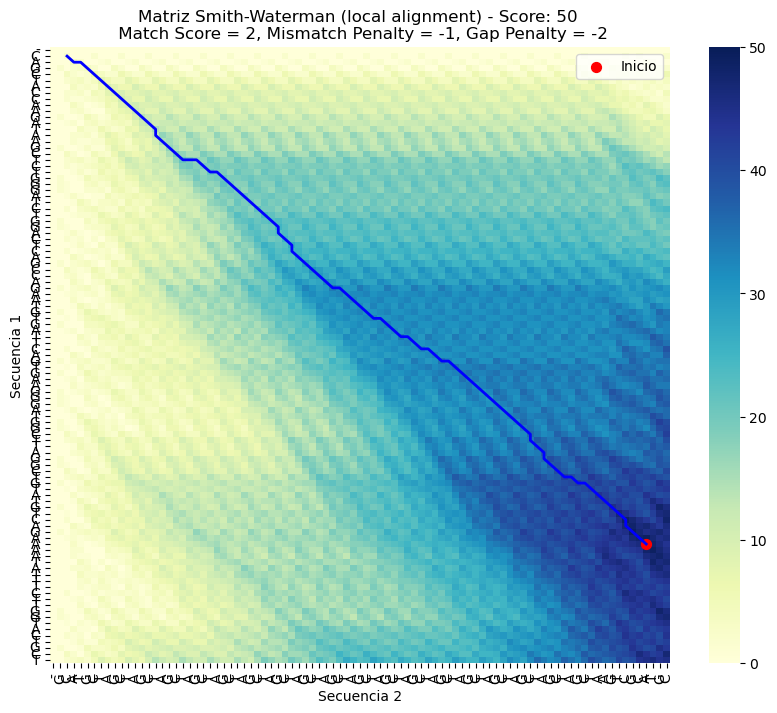

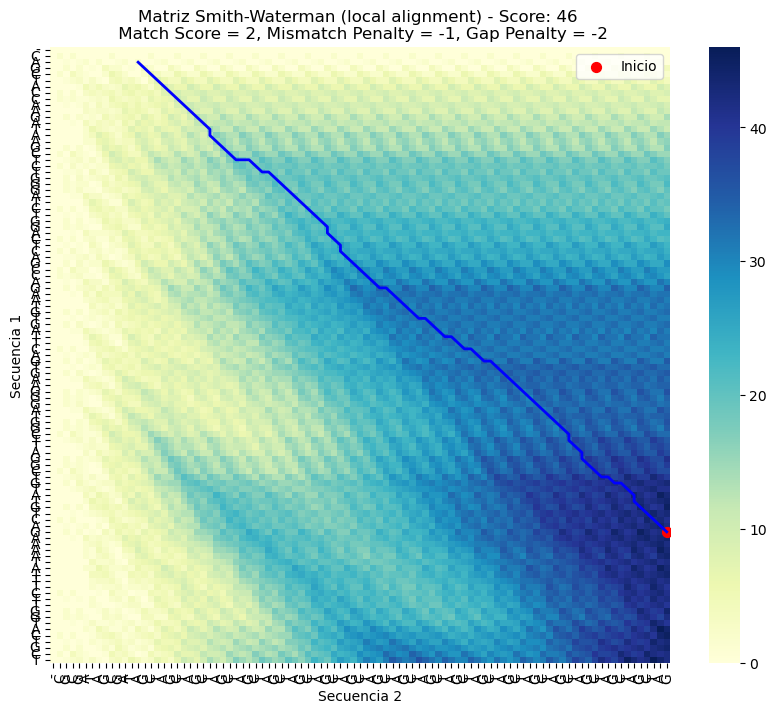

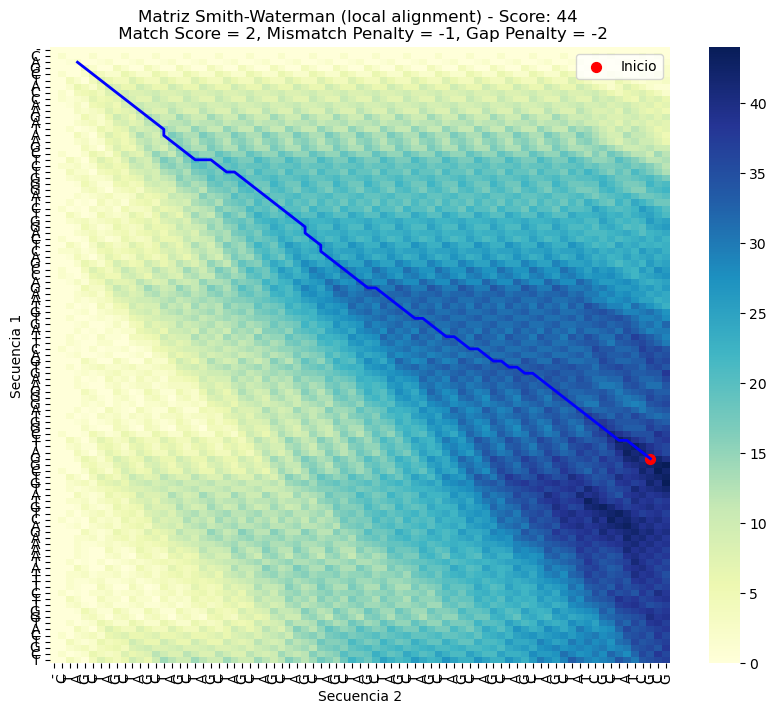

In [57]:
# List to save the results (score, sequence)
results = []


for i in range(1, len(pairs)+1):  
    # key to the dictionary  
    llave = f'pair{i}'

    # algorithm for the original sequence
    algorithm_og = smith_waterman(original_sequence, pairs[llave][0], 2, -1, -2)

    # algorithm for the reversed sequence
    algorithm_reverse = smith_waterman(original_sequence, pairs[llave][1], 2, -1, -2)

    # Save both scores
    score_og = algorithm_og[2]
    score_reverse = algorithm_reverse[2]

    # Add them to the list
    results.append((score_og, f"pair{i}"))
    results.append((score_reverse, f"pair{i}_reverse"))

# Sort the results by score in descending order
sorted_results = sorted(results, key=lambda x: x[0], reverse=True)

# Take the top 3
top_3 = sorted_results[:3]
print(f'Top 3 sequences & their score: {top_3}')

# <font color= #bbc28d> **Parameter Sensitivity - SW** </font>
Modify match/mismatch/gap parameters and re-run alignment on 3 selected pairs. For this, the 3 scenarios we will try are the following:

- **Case 1**: Match score of `1`, mismatch penalty of `-10` & gap penalty `-1`.
- **Case 2**: Match score of `10`, mismatch penalty of `-1` & gap penalty `-1`.
- **Case 3**: Match score of `3`, mismatch penalty of `-1` & gap penalty `-2`.

Here are the scores with match: 1, mismatch: -10 & penalty -1
[(11, 'pair2_reverse'), (9, 'pair3_reverse'), (8, 'pair3')]


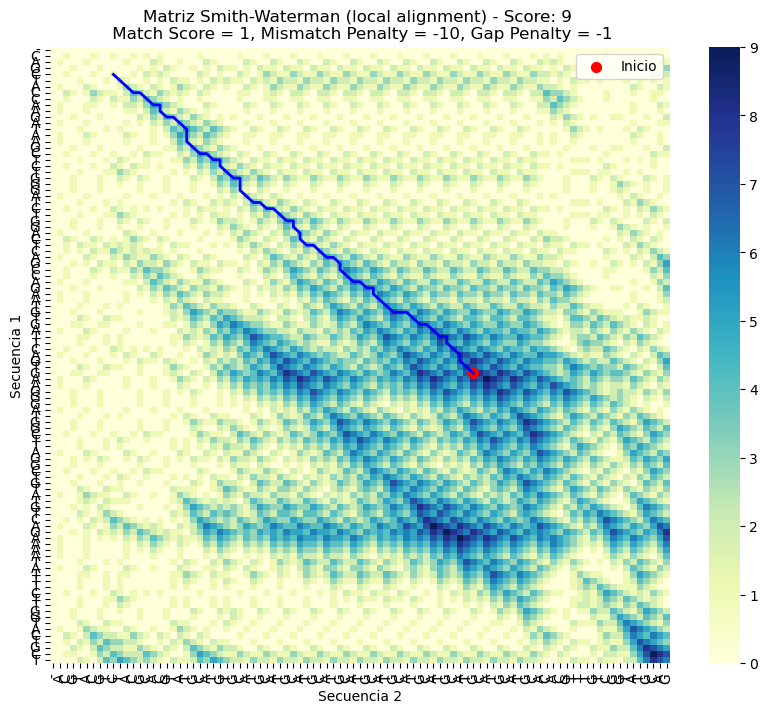

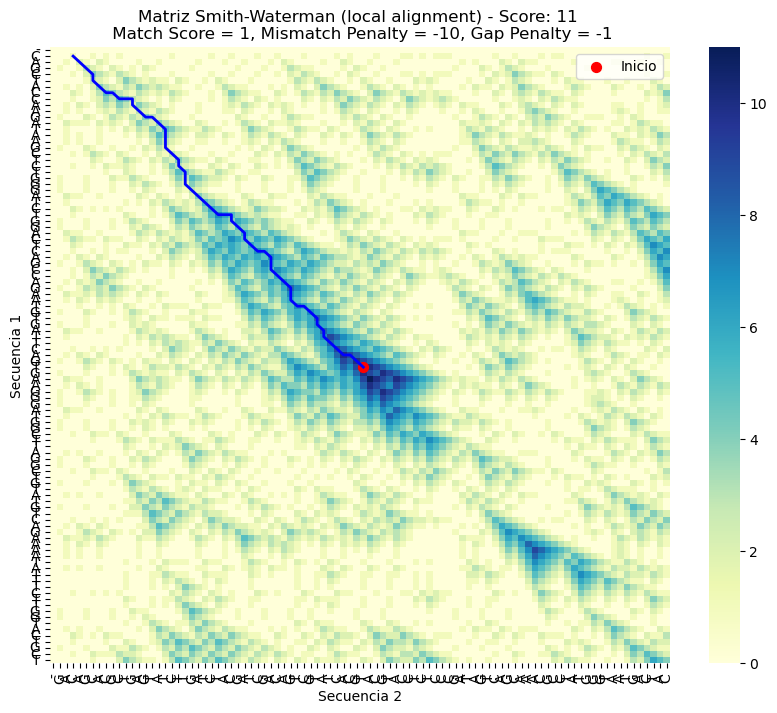

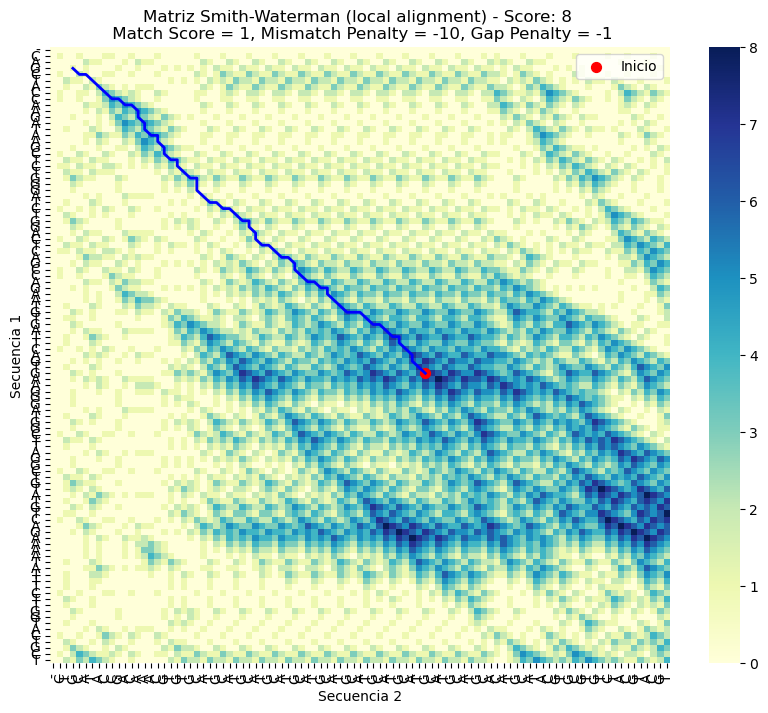

In [58]:
# Select the top 3 highest scoring pairs
pairs_params = list(map(lambda x: x[1], top_3))

# Save the score and name of the sequence
results = []

# Parameters
Match = 1
Mismatch = -10
Gap = -1


for name in pairs_params:
    # Check if it's the reversed sequence
    if name.endswith("_reverse"):
        # Change the key 
        key = name.replace("_reverse", "")
        sequence = pairs[key][1]  # take the reversed sequence
    else:
        sequence = pairs[name][0]  # take the original sequence
    
    # Apply the algorithm
    algorithm = smith_waterman(original_sequence, sequence, Match, Mismatch, Gap)

    # Save the score
    score = algorithm[2]
    results.append((score, name))

# Sort the scores from highest to lowest
results = sorted(results, key=lambda x: x[0], reverse=True)
print(f'Here are the scores with match: {Match}, mismatch: {Mismatch} & penalty {Gap}')
print(results)

Here are the scores with match: 10, mismatch: -1 & penalty -1
[(605, 'pair2_reverse'), (601, 'pair3'), (596, 'pair3_reverse')]


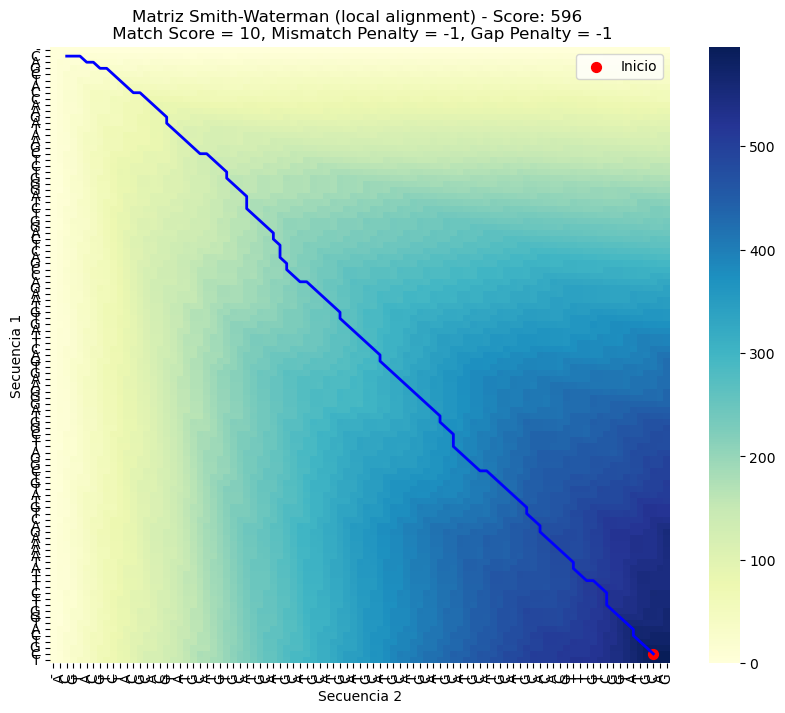

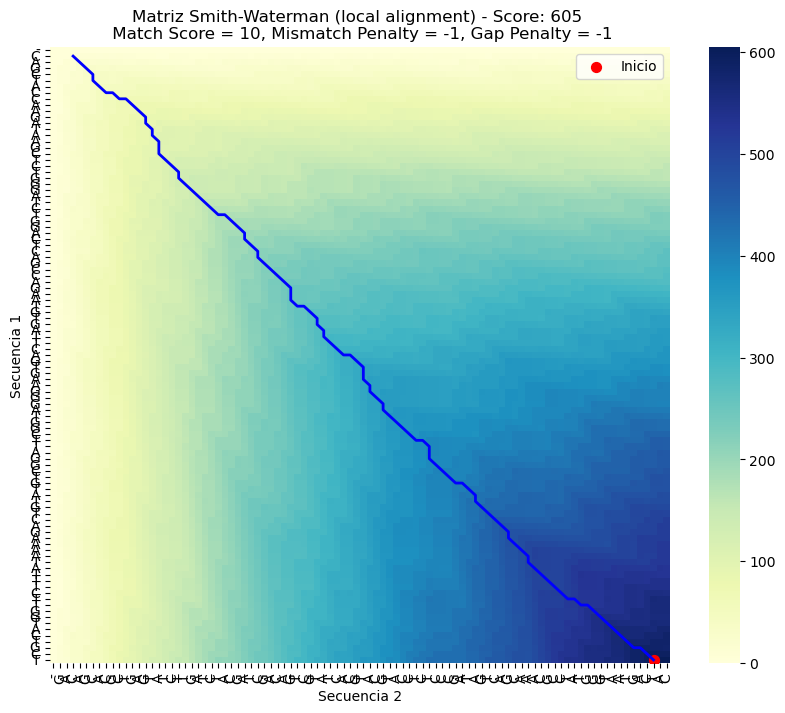

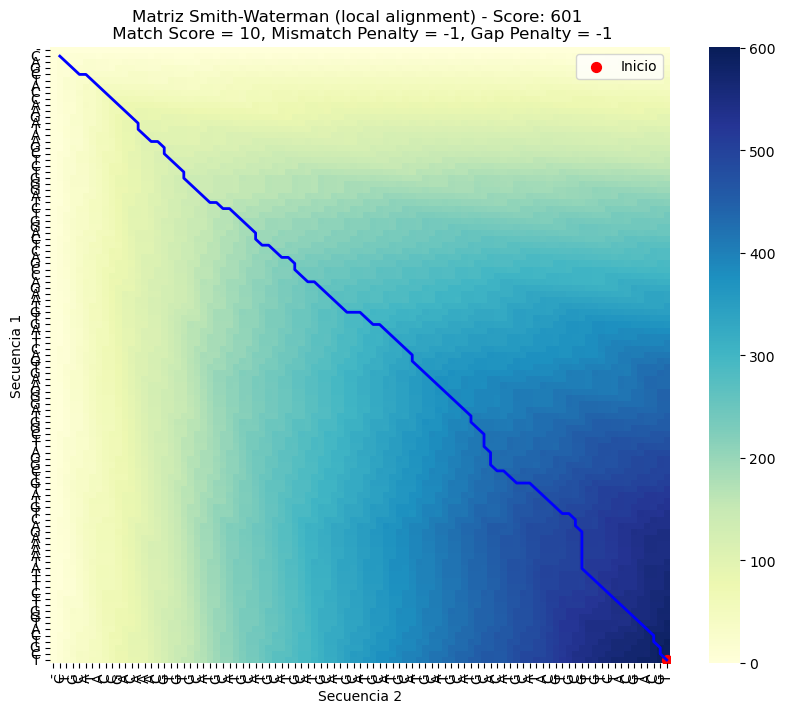

In [59]:
# Save the score and name of the sequence
results = []

# Parameters
Match = 10
Mismatch = -1
Gap = -1


for name in pairs_params:
    # Check if it's the reversed sequence
    if name.endswith("_reverse"):
        # Change the key 
        key = name.replace("_reverse", "")
        sequence = pairs[key][1]  # take the reversed sequence
    else:
        sequence = pairs[name][0]  # take the original sequence
    
    # Apply the algorithm
    algorithm = smith_waterman(original_sequence, sequence, Match, Mismatch, Gap)

    # Save the score
    score = algorithm[2]
    results.append((score, name))

# Sort the scores from highest to lowest
results = sorted(results, key=lambda x: x[0], reverse=True)
print(f'Here are the scores with match: {Match}, mismatch: {Mismatch} & penalty {Gap}')
print(results)

Here are the scores with match: 3, mismatch: -1 & penalty -2
[(122, 'pair3_reverse'), (121, 'pair2_reverse'), (119, 'pair3')]


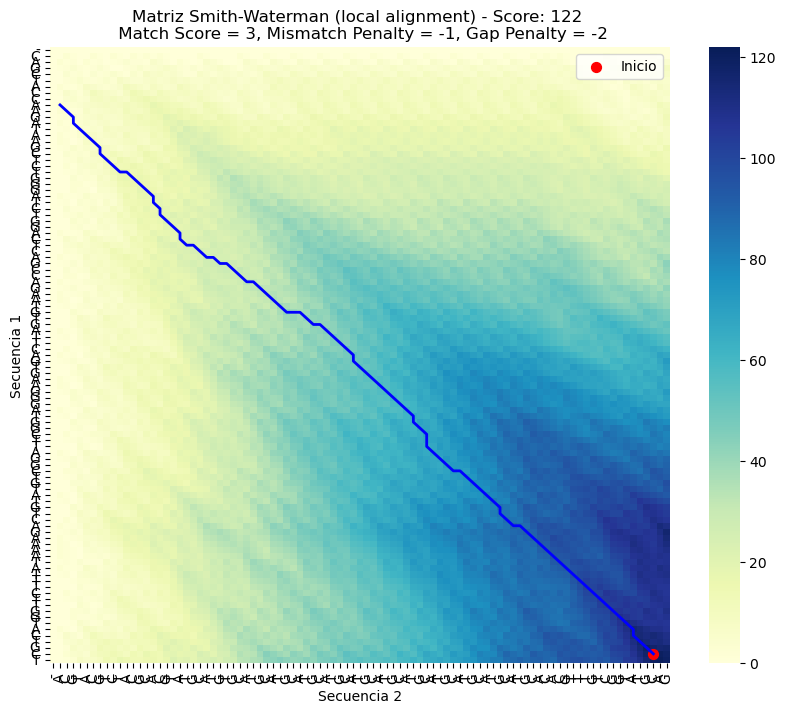

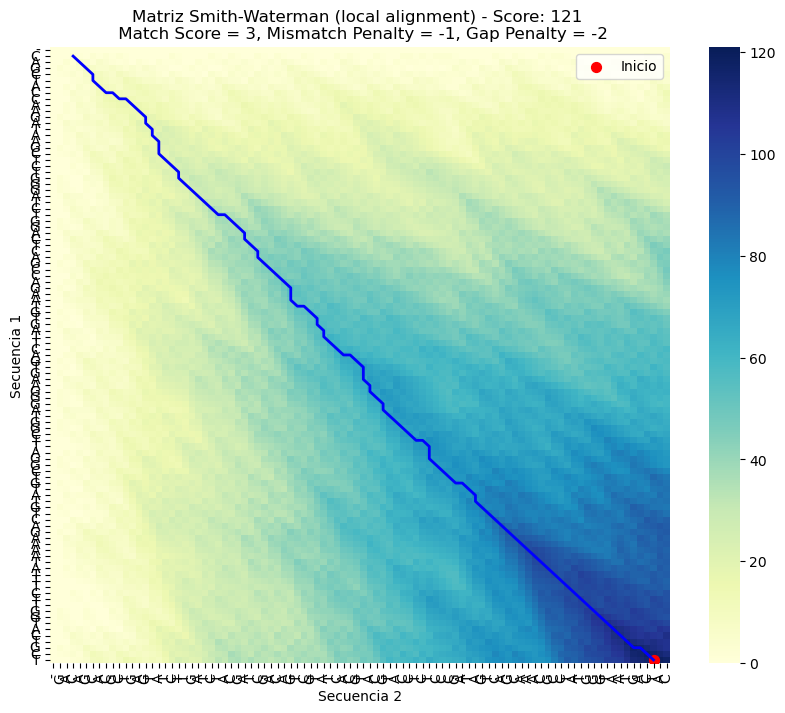

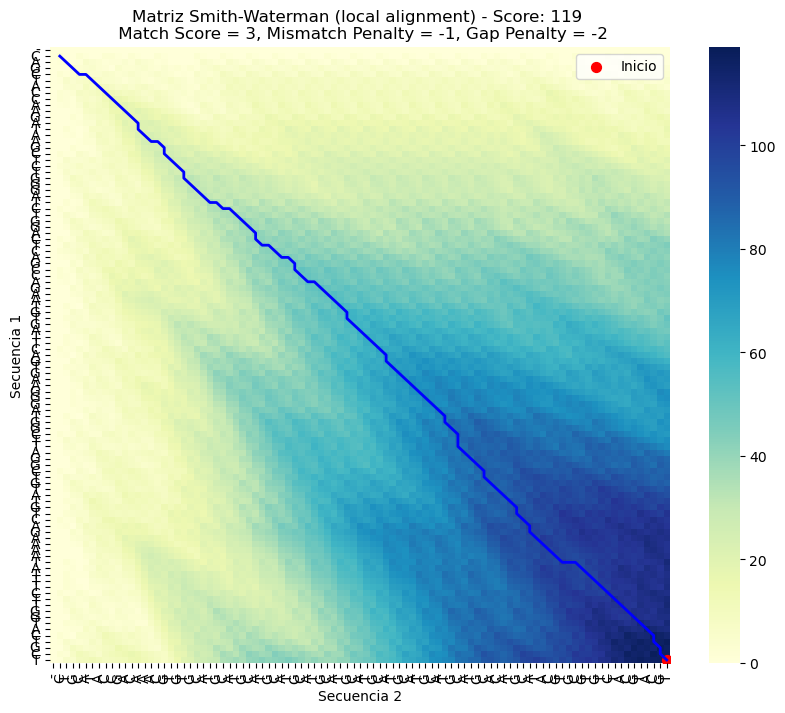

In [60]:
# Save the score and name of the sequence
results = []

# Parameters
Match = 3
Mismatch = -1
Gap = -2


for name in pairs_params:
    # Check if it's the reversed sequence
    if name.endswith("_reverse"):
        # Change the key 
        key = name.replace("_reverse", "")
        sequence = pairs[key][1]  # take the reversed sequence
    else:
        sequence = pairs[name][0]  # take the original sequence
    
    # Apply the algorithm
    algorithm = smith_waterman(original_sequence, sequence, Match, Mismatch, Gap)

    # Save the score
    score = algorithm[2]
    results.append((score, name))

# Sort the scores from highest to lowest
results = sorted(results, key=lambda x: x[0], reverse=True)
print(f'Here are the scores with match: {Match}, mismatch: {Mismatch} & penalty {Gap}')
print(results)

### <font color= #bbc28d> **Comparison with Biopython - NW** </font>

In [61]:
### Biopython
# Start the timer
start = time.perf_counter()

# Implementing Bio's algorithm
alignments = pairwise2.align.globalms(original_sequence,pairs['pair3'][0], 2, -1, -1, 0)

# Print the results
print(f'Time taken: {(time.perf_counter() - start):.10f}')
print(pairwise2.format_alignment(*alignments[0])) # The different score is due to different parameters

Time taken: 0.0080979000
CAGC-TACCAAGATAA--GCTCTGGG-AT-C-TGGAC-T-CA-GCCA-GAATG--TG-ATTCAGTGAAGGGATG-----GCTTA-G-GCTGTATGTCAGAAAATATTTCTTGGTACTGCT
|.|| ||||  ||.||  |   ||.| || | ||  | | || | || |.|||  || ||.|| ||.|.|.|||     ||.|| | || |  ||||      ||   |   |||| | |
CTGCATACC--GACAAACG---TGTGCATGCATG--CATGCATG-CATGCATGCATGCATGCA-TGCATGCATGCACATGCATACGTGC-G--TGTC------TA---C---GTAC-G-T
  Score=95



===Aligned Sequence: -ACGTA-C-GTCTACGCACGTATGCATGTGCA-T--GCATGCATG-CATGCA-TGCATGCAT-GCAT-GCATGCATG-CATGCACACGTTTGTCGGTA-TGCAG
===Aligned Sequence: CAGCTACCAAGATAAGCTC-T-GGGATCTGGACTCAGCCAGAATGTGATTCAGTGAAGGGATGGCTTAGGCTGTATGTCA-GAAAATATTTCTTGGTACTGC-T
===Alignment Score: 54.0
===Time Taken: 0.0475588000


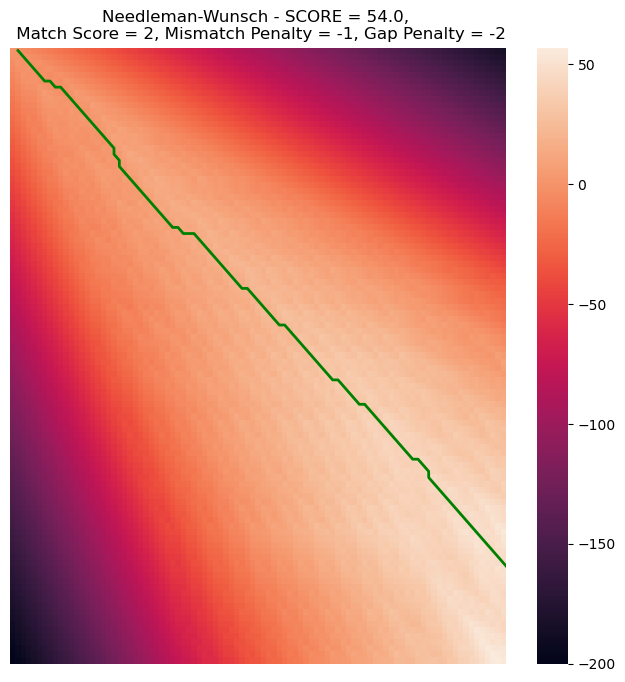

In [62]:
### From Scratch
nw = needleman_wunsch(original_sequence,pairs['pair3'][1],2,-1,-2)
print(f"===Aligned Sequence: {nw[1]}")
print(f"===Aligned Sequence: {nw[2]}")
print(f"===Alignment Score: {nw[3]}")
print(f"===Time Taken: {nw[4]:.10f}")

### <font color= #bbc28d> **Comparison with Biopython - SW** </font>

In [63]:
### Biopython
# Start the timer
start = time.perf_counter()

# Implementing Bio's algorithm
alignments =  pairwise2.align.localms(original_sequence,pairs['pair3'][0], 2, -1, -1, 0)

# Print the results
print(f'Time taken: {(time.perf_counter() - start):.10f}')
print(pairwise2.format_alignment(*alignments[0])) # The different score is due to different parameters

Time taken: 0.0087092000
CAGC-TACCAAGATAA--GCTCTGGG-AT-C-TGGAC-T-CA-GCCA-GAATG--TG-ATTCAGTGAAGGGATG-----GCTTA-G-GCTGTATGTCAGAAAATATTTCTTGGTACTGCT
|.|| ||||  ||.||  |   ||.| || | ||  | | || | || |.|||  || ||.|| ||.|.|.|||     ||.|| | || |  ||||      ||   |   |||| | |
CTGCATACC--GACAAACG---TGTGCATGCATG--CATGCATG-CATGCATGCATGCATGCA-TGCATGCATGCACATGCATACGTGC-G--TGTC------TA---C---GTAC-G-T
  Score=95



===Aligned Sequence: AC-CAAG-ATAAGCTC-T-GGGATCTGGACTCAGCCAGAATGTGATTCAGTGAAGGGATGGCTTAGGCTGTATGTCA-GAAAATATTTCTTGGTACTGC
===Aligned Sequence: ACGTACGTCTACGCACGTATGCATGTGCA-T--GCATGCATG-CATGCA-TGCATGCAT-GCAT-GCATGCATG-CATGCACACGTTTGTCGGTA-TGC
===Alignment Score: 61
===Time Taken: 0.0565299000


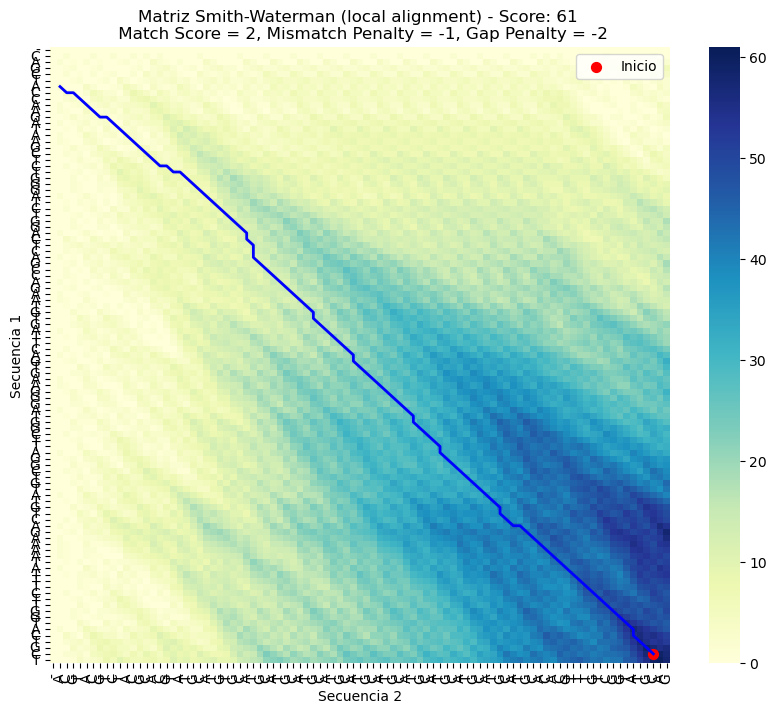

In [64]:
### From Scratch
sw = smith_waterman(original_sequence,pairs['pair3'][1],2,-1,-2)
print(f"===Aligned Sequence: {sw[0]}")
print(f"===Aligned Sequence: {sw[1]}")
print(f"===Alignment Score: {sw[2]}")
print(f"===Time Taken: {sw[4]:.10f}")

Comparing our results with Biopython, the aligned sequences are **slightly different**. Smith-Waterman looks for local matches, so there can be multiple valid alignments. Our goal was to implement the algorithms from scratch, not to exactly match Biopython, so scores and sequences differ.

Parameters also affect the results. In our code, we use a single gap penalty with match and mismatch scores, however Biopython allows separate `gap open` and `gap extension` penalties, so starting a gap can cost more than extending it.

Finally, Biopython may include `additional optimizations` internally, which can also slightly change both the alignments and the reported scores.